# Deepportfolio

A methodology that explores to design ortfolios based on identifying non-linear relationships between stocks


In [75]:
import copy

import pandas as pd
import numpy as np


from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
import keras.backend as K

from sklearn.preprocessing import StandardScaler  
import src.utils.returns_preprocessing as preproc
import src.utils.portfolio_utils as portfolio_utils
import src.pca.eigen_portfolios_functions as eg_functions


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the data

In [68]:
# load from persisted data
df_prices = pd.read_csv('./data/all_stock_prices.csv')
df_prices.index = df_prices['Unnamed: 0']
df_prices = df_prices.drop('Unnamed: 0', axis = 1)
df_prices.head()

^BVSP  TAEE11.SA   PETR4.SA   BBDC4.SA   BBAS3.SA   GGBR4.SA  \
Unnamed: 0                                                                   
2013-01-15  61728.0  22.799999  19.820000  13.292220  26.700001  17.920000   
2013-01-16  61787.0  22.600000  19.840000  13.359929  26.860001  17.889999   
2013-01-17  62194.0  22.799999  19.709999  13.580872  26.809999  18.100000   
2013-01-18  61956.0  23.500000  19.580000  13.630762  26.200001  17.900000   
2013-01-21  61900.0  23.200001  19.389999  13.573744  25.930000  17.900000   

            ITSA4.SA   VALE3.SA  USIM5.SA  B3SA3.SA  
Unnamed: 0                                           
2013-01-15  5.420308  41.160000     12.32  4.516666  
2013-01-16  5.451914  40.900002     12.20  4.466666  
2013-01-17  5.541462  40.980000     12.46  4.600000  
2013-01-18  5.557265  40.610001     12.30  4.640000  
2013-01-21  5.546730  40.580002     12.03  4.663333

In [69]:
# load test results - equivalent to the index returns to compare with
import pickle
with open("./data/eigen_portfolios_test_pickle_normalized_weights.pickle", "rb") as infile:
    eigen_portfolios_test = pickle.load(infile)

<AxesSubplot:>

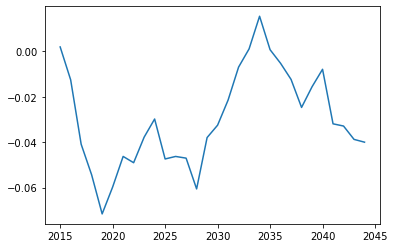

In [70]:
# set a test return
sector_returns = eigen_portfolios_test[5]
sector_returns['test_cumulative_returns'].plot()

<AxesSubplot:>

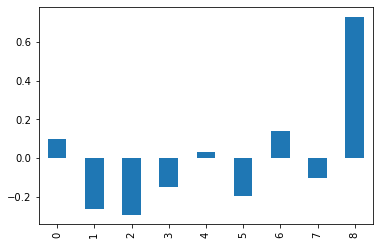

In [71]:
pd.Series(sector_returns['weights']).plot.bar()

### Preprocessing

In [72]:
## this is a bad criterion - it only seek for shocks!
def set_target_returns_extreme_effects_by_percentile(y_returns, quantile = .01, risk_free_rate = None):
    
    y_train_amended = y_returns.copy()
    
    treshold = y_returns.quantile(quantile)
    if risk_free_rate is None:
        risk_free_rate = treshold + (np.abs(treshold)*0.8)
    
    y_train_amended[y_train_amended < treshold] = risk_free_rate
        
    return y_train_amended

## new criterion: set a target 
#fazer uma curva, se quero outperform ( exceso. de 1%) diliu essa porcentagem no tamanho da minha mostra de treino, e fazer com um grid de 1%, 2%, 3%,...... x -> grid; y -> sharpe (para cada iteração!) 

#fazer curva do sharpe em função da curva que estou procurando!
# a metrica boa é usar o sharpe e a serie

def set_target_spreaded_rate(y_returns, risk_free_rate = None):
    """
    Added annualy
    """
    if risk_free_rate is None:
        risk_free_rate = 0.05
    add_each_day = risk_free_rate/252 
    ammended_returns = y_returns + add_each_day
    return ammended_returns

In [73]:
index_ticker ='^BVSP'

df_returns = preproc.get_normal_returns_from_prices(df_prices)
df_returns_without_index = df_returns.drop(index_ticker, axis = 1)



### setting objective

According to literature, several articles tend to beat the index by diregarding high correaltion/covariance periods replacing the drops inder certain treshold to a predefined one

For the brazilian market, different from others indexes, drops are quite severe, hnce high correlations regimes are for drops higher than 20% in the overall sample

In [77]:
# test experiment
# split in train and test
test_period = 150
train_history = 252
date = '2014-01-02'
risk_free_rate = 0.05
index_ticker ='^BVSP'
high_correlation_treshold = 0.25 # depending of the sector an statistical analysis might be performed
df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns_without_index, date, train_history, test_period)

# y_train
y_train = portfolio_utils.get_portfolio_returns(df_returns_train, sector_returns['weights'], is_log = False)
# caluclate according to the sample te porcentage to reeplace
#y_train_amended = set_target_returns_extreme_effects_by_percentile(y_train)
y_train_amended = set_target_spreaded_rate(y_train, risk_free_rate)

# y_test
y_test = portfolio_utils.get_portfolio_returns(df_returns_test, sector_returns['weights'], is_log = False)
# caluclate according to the sample te porcentage to reeplace
#y_test_amended = set_target_returns_extreme_effects_by_percentile(y_test)
y_test_amended = set_target_spreaded_rate(y_test, risk_free_rate)


<AxesSubplot:>

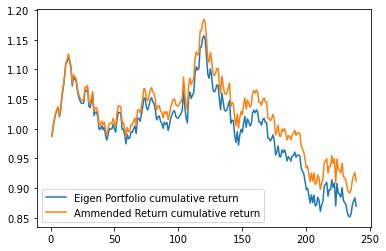

In [9]:
y_reference = y_train.copy()
y_reference[0] = 0
relative_percentage_reference = y_train + 1
lp_reference =  (relative_percentage_reference.cumprod())


#relative_percentage = (y_amended /100) + 1
relative_percentage = y_train_amended  + 1
lp_amended =  (relative_percentage.cumprod()) 


# plot comparison
#pd.Series(np.array(y_reference), index=pd.date_range(start='01/06/2012', periods=240, freq='W')).plot(label='Eigen Portfolio Return', legend=True) 
#pd.Series(np.array(y_amended), index=pd.date_range(start='01/06/2012', periods=240, freq='W')).plot(label='Ammended Return', legend=True)   

pd.Series(np.array(lp_reference)).plot(label='Eigen Portfolio cumulative return', legend=True) 
pd.Series(np.array(lp_amended)).plot(label='Ammended Return cumulative return', legend=True)   



In [15]:
test_ref = pd.Series(np.array(lp_reference))
test_ammended = pd.Series(np.array(lp_amended))

#return_ref = (test_ref[298] - test_ref[0]) / test_ref[0]
#return_ammended = (test_ammended[298] - test_ammended[0]) / test_ammended[0]

In [123]:
test_ref[0]*1.34818688220803445

1.3403254590386775

### Autoencoding part

Phase 1. Auto-encoding
- Train an auto-encoder model compressing market information.
- Rank stocks by 2-norm difference then select subset of them as our portfolio.
- Page 7 of the paper: ReLU + linear as activation functions
- Weights , L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):

- which weekly return/what data to be used? (what can represent best market information?)
- How to do the data preprocessing?
- How to perform 4-fold validation in Deep Learning?

### Autoencoding

For this we foxus only in start from the calibration section as the index itself is not a problem to represent

### Conclusion

The restrictions of the last layer,only allow us to use holding strategy (as softmx works well when ever the weights are positive and added up turns 1). other startegies such as shorting, still don't converge to a reasonable sets of weights.

This impose a problem as to when the eigen vectors are released, the returns described by them, are not possible to replicate with an autoencoder as it is designed now, (at least at this stage), due to some eigenvectors certainly are significant leveraged (which means, normalized acrivations are not )

The authors said that evolving to other startegies, is a work in progress, as such, working with other activation functions 



NOTE: PERHAPS, BY WORKING WITH LOG-RETURNS, LEVERAGED EIGENPORTFOLIOS OR EIGENVECTORS WITH COMPONENTS SIGNIFICANT BIGGER THAN ONE, MIGHT BE REDUCED

In [146]:
encoder_params = {'encoding_dim': 5,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'tanh'} # not working with short positions

short_model = autoencoder_short_portfolio_calibration_fit(df_returns_train[1:], y_train_amended[1:], encoder_params)



Epoch 1/500
3/3 [==============================] - 0s 2ms/step - loss: 0.4050
Epoch 2/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3853
Epoch 3/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3687
Epoch 4/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3544
Epoch 5/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3420
Epoch 6/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3310
Epoch 7/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3213
Epoch 8/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3125
Epoch 9/500
3/3 [==============================] - 0s 2ms/step - loss: 0.3046
Epoch 10/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 11/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2907
Epoch 12/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2846
Epoch 13/500
3/3 [==============================] - 0s 2ms/st

3/3 [==============================] - 0s 1ms/step - loss: 0.1314
Epoch 207/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1312
Epoch 208/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1310
Epoch 209/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1308
Epoch 210/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1306
Epoch 211/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1304
Epoch 212/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1302
Epoch 213/500
3/3 [==============================] - 0s 2ms/step - loss: 0.1300
Epoch 214/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1298
Epoch 215/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1296
Epoch 216/500
3/3 [==============================] - 0s 2ms/step - loss: 0.1294
Epoch 217/500
3/3 [==============================] - 0s 1ms/step - loss: 0.1292
Epoch 218/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 1ms/step - loss: 0.0992
Epoch 411/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0991
Epoch 412/500
3/3 [==============================] - 0s 2ms/step - loss: 0.0989
Epoch 413/500
3/3 [==============================] - 0s 2ms/step - loss: 0.0988
Epoch 414/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0987
Epoch 415/500
3/3 [==============================] - 0s 2ms/step - loss: 0.0986
Epoch 416/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0984
Epoch 417/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 418/500
3/3 [==============================] - 0s 2ms/step - loss: 0.0982
Epoch 419/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0981
Epoch 420/500
3/3 [==============================] - 0s 1ms/step - loss: 0.0979
Epoch 421/500
3/3 [==============================] - 0s 2ms/step - loss: 0.0978
Epoch 422/500
3/3 [==============================] - 0

In [147]:
y_train_short = np.array(short_model.predict(df_returns_train[1:]))

8/8 [==============================] - 0s 761us/step


<AxesSubplot:>

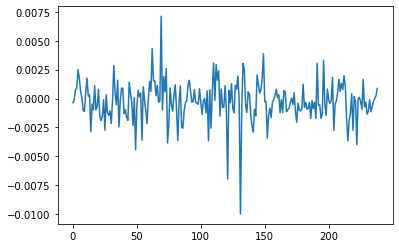

In [149]:

pd.Series(y_train_short[:,0]).plot()


<AxesSubplot:xlabel='Unnamed: 0'>

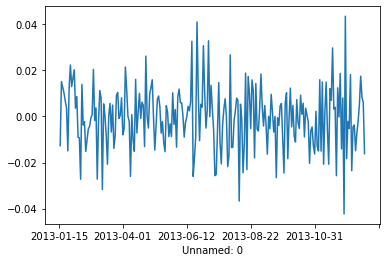

In [151]:
pd.Series(y_train).plot()

max: 0.2742798796682955
mean: -0.1974386606102669


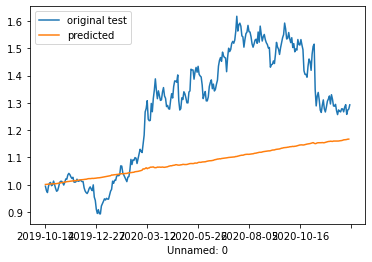

In [141]:
lp_test =  ((y_train + 1).cumprod())

lp_test_ammended =  ((y_train_amended + 1).cumprod())

lp_predicted =((y_train_short[:,0]  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
#pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

# bad training! ??? it seems so!
diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

In [42]:
encoder_params = {'encoding_dim': 5,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'softmax'}


model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_amended[1:], encoder_params)

Epoch 1/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9095
Epoch 2/500


2023-02-10 20:07:28.886386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 0s 12ms/step - loss: 0.9093
Epoch 3/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9091
Epoch 4/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9089
Epoch 5/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9087
Epoch 6/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9085
Epoch 7/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9083
Epoch 8/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9081
Epoch 9/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9079
Epoch 10/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9077
Epoch 11/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9075
Epoch 12/500
3/3 [==============================] - 0s 15ms/step - loss: 0.9073
Epoch 13/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9071
Epoch 14/500
3/3 [==============================] - 0s 13ms/

3/3 [==============================] - 0s 10ms/step - loss: 0.8736
Epoch 206/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8734
Epoch 207/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8733
Epoch 208/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8731
Epoch 209/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8730
Epoch 210/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8728
Epoch 211/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8727
Epoch 212/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8725
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8724
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8722
Epoch 215/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8721
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8719
Epoch 217/500
3/3 [============================

3/3 [==============================] - 0s 9ms/step - loss: 0.8590
Epoch 308/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8588
Epoch 309/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8587
Epoch 310/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8586
Epoch 311/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8584
Epoch 312/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8583
Epoch 313/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8582
Epoch 314/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8581
Epoch 315/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8579
Epoch 316/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8578
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8577
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8575
Epoch 319/500
3/3 [============================

3/3 [==============================] - 0s 10ms/step - loss: 0.8462
Epoch 410/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8461
Epoch 411/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8460
Epoch 412/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8459
Epoch 413/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8457
Epoch 414/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8456
Epoch 415/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8455
Epoch 416/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8454
Epoch 417/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8453
Epoch 418/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8452
Epoch 419/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8450
Epoch 420/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8449
Epoch 421/500
3/3 [==============================] -

#### 

## validating

# how do I resolve the portfolios with short positions?? softmax only accepts hold ... ASK Edson Why tanh does not work, this is needed to replicate eigenportfolios with short positions!

10/10 [==============================] - 0s 761us/step


<AxesSubplot:xlabel='Unnamed: 0'>

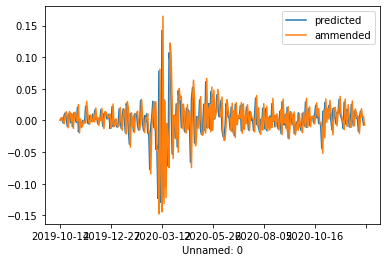

In [43]:
# train
portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model))
pd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)
#portfolio_returns_train_hat.plot(label = 'predicted', legend = True)
y_train_amended.plot(label = 'ammended', legend = True)

max: 0.781263591986098
mean: 0.014903781449533924


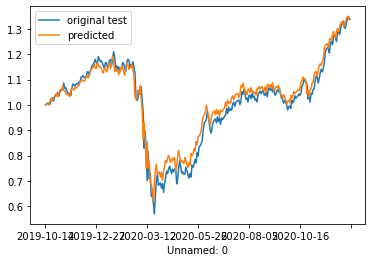

In [976]:
lp_test =  ((y_train + 1).cumprod())

lp_test_ammended =  ((y_train_amended + 1).cumprod())

lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
#pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

# bad training! ??? it seems so!
diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

max: 0.775529609647077
mean: 0.01166474081134997


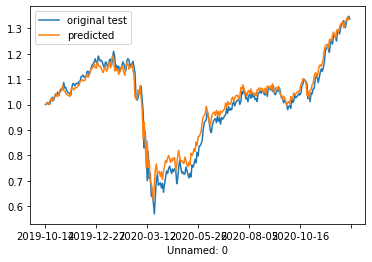

In [982]:
lp_test =  ((y_train + 1).cumprod())

lp_test_ammended =  ((y_train_amended + 1).cumprod())

lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
#pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

# bad training! ??? it seems so!
diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

## Important!

This results show that no convergence was hit, as what it has been predicted does not represent the returns intented to learn s they were generated by weights, or eigenvectors that are not possible to get from the current autoencoder architecture!

5/5 [==============================] - 0s 939us/step


<AxesSubplot:xlabel='Unnamed: 0'>

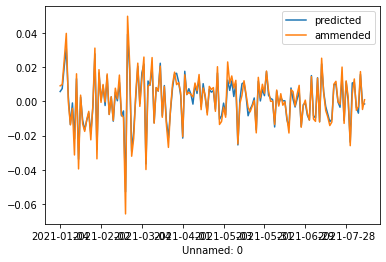

In [44]:
# test
portfolio_returns_hat = pd.Series(portfolio_returns_predict(df_returns_test.dropna(), model))
#pd.Series(portfolio_returns_hat[:,0]).plot(label = 'predicted', legend = True)
portfolio_returns_hat.plot(label = 'predicted', legend = True)
y_test_amended.plot(label = 'ammended', legend = True)

max: 0.2351595047247288
mean: 0.014230873550640889


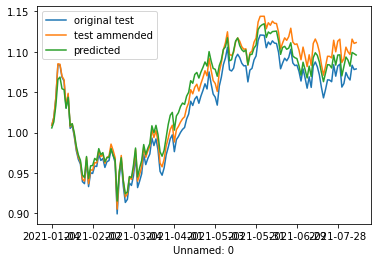

In [47]:
lp_test =  ((y_test + 1).cumprod())

lp_test_ammended =  ((y_test_amended + 1).cumprod())

lp_predicted =((portfolio_returns_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))


max: 0.2351595047247288
mean: 0.014230873550640889


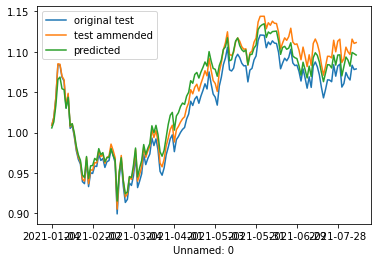

In [46]:
lp_test =  ((y_test + 1).cumprod())

lp_test_ammended =  ((y_test_amended + 1).cumprod())

lp_predicted =((portfolio_returns_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

# Experiments

In [58]:
import datetime
base = datetime.datetime.strptime('2013-03-01','%Y-%m-%d')

date_iterations = [(base + datetime.timedelta(days = (30*x))).strftime('%Y-%m-%d') for x in range(100)]

def execute_experiment(df_returns, train_history = 300, test_period = 30, date_iterations = [], risk_free_rate = 0.05):
    
    experiments_cache = {}
    for _date in date_iterations:
        
        ##### preprocessing ####
        df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns, _date, train_history, test_period)
        df_returns_train = df_returns_train[1:].copy()
        
        # y_train
        y_train = eg_functions.get_portfolio_returns(df_returns_train, sector_returns['weights'], is_log = False)
        y_train_amended = set_target_spreaded_rate(y_train, risk_free_rate)

        # y_test
        y_test = eg_functions.get_portfolio_returns(df_returns_test, sector_returns['weights'], is_log = False)
        y_test_amended = set_target_spreaded_rate(y_test, risk_free_rate)
        
        #### training part ####
        encoder_params = {'encoding_dim': 9,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'softmax'}
        
        model = autoencoder_portfolio_calibration_fit(df_returns_train, y_train_amended, encoder_params)
        
        
        #### predict ####
        #train
        portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train, model))
        #test
        portfolio_returns_test_hat = pd.Series(portfolio_returns_predict(df_returns_test.dropna(), model))
        #cumulative test
        lp_test =  ((y_test + 1).cumprod())
        lp_test_ammended =  ((y_test_amended + 1).cumprod())
        lp_predicted_test = ((portfolio_returns_test_hat  + 1).cumprod()) 
        diff_test_benchmark = [lp_predicted_test[i] - lp_test[i]  for i in range(len(lp_predicted_test))]
       
        #cumulative train
        lp_train =  ((y_train + 1).cumprod())
        lp_train_ammended =  ((y_train_amended + 1).cumprod())
        lp_predicted_train = ((portfolio_returns_train_hat  + 1).cumprod()) 
        diff_train_benchmark = [lp_predicted_train[i] - lp_train[i] for i in range(len(lp_predicted_train))]

        
        train_cache = {
            'portfolio_returns_pred':portfolio_returns_train_hat,
            'lp':lp_train,
            'lp_ammended':lp_train_ammended,
            'lp_predicted':lp_predicted_train,
            'diff_pred_benchmark':diff_train_benchmark
        }
        
        test_cache = {
            'portfolio_returns_pred':portfolio_returns_test_hat,
            'lp':lp_test,
            'lp_ammended':lp_test_ammended,
            'lp_predicted':lp_predicted_test,
            'diff_pred_benchmark':diff_test_benchmark
        }
        
        experiments_cache[_date] = {'train':train_cache , 'test': test_cache}
        
    return experiments_cache


experiments_cache = execute_experiment(df_returns_without_index, train_history = 300, test_period = 150, date_iterations = date_iterations)


Epoch 1/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7633
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7631
Epoch 3/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7629
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7628
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7626
Epoch 6/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7625
Epoch 7/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7623
Epoch 8/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7622
Epoch 9/500
1/1 [==============================] - 0s 18ms/step - loss: 0.7620
Epoch 10/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7618
Epoch 11/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7617
Epoch 12/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7615
Epoch 13/500
1/1 [==============================]

1/1 [==============================] - 0s 14ms/step - loss: 0.7345
Epoch 205/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7344
Epoch 206/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7343
Epoch 207/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7342
Epoch 208/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7340
Epoch 209/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7339
Epoch 210/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7338
Epoch 211/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7337
Epoch 212/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7335
Epoch 213/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7334
Epoch 214/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7333
Epoch 215/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7332
Epoch 216/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7109
Epoch 407/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7108
Epoch 408/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7107
Epoch 409/500
1/1 [==============================] - 0s 18ms/step - loss: 0.7106
Epoch 410/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7105
Epoch 411/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7104
Epoch 412/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7103
Epoch 413/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7102
Epoch 414/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7101
Epoch 415/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7100
Epoch 416/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7099
Epoch 417/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7098
Epoch 418/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7593
Epoch 109/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7592
Epoch 110/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7591
Epoch 111/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7590
Epoch 112/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7588
Epoch 113/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7587
Epoch 114/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7586
Epoch 115/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7585
Epoch 116/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7584
Epoch 117/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7583
Epoch 118/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7581
Epoch 119/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7580
Epoch 120/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7368
Epoch 311/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7367
Epoch 312/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7366
Epoch 313/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7365
Epoch 314/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7364
Epoch 315/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7363
Epoch 316/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7362
Epoch 317/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7361
Epoch 318/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7360
Epoch 319/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7359
Epoch 320/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7358
Epoch 321/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7357
Epoch 322/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7760
Epoch 12/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7759
Epoch 13/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7758
Epoch 14/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7757
Epoch 15/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7755
Epoch 16/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7754
Epoch 17/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7753
Epoch 18/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7752
Epoch 19/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7751
Epoch 20/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7749
Epoch 21/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7748
Epoch 22/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7747
Epoch 23/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.7528
Epoch 215/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7527
Epoch 216/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7526
Epoch 217/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7525
Epoch 218/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7524
Epoch 219/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7523
Epoch 220/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7522
Epoch 221/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7521
Epoch 222/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7520
Epoch 223/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7519
Epoch 224/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7518
Epoch 225/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7516
Epoch 226/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.7322
Epoch 417/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7321
Epoch 418/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7320
Epoch 419/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7319
Epoch 420/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7318
Epoch 421/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7317
Epoch 422/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7316
Epoch 423/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7315
Epoch 424/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7314
Epoch 425/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7313
Epoch 426/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7312
Epoch 427/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7311
Epoch 428/500
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.8037
Epoch 119/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8036
Epoch 120/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8034
Epoch 121/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8033
Epoch 122/500
1/1 [==============================] - 0s 12ms/step - loss: 0.8031
Epoch 123/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8030
Epoch 124/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8029
Epoch 125/500
1/1 [==============================] - 0s 12ms/step - loss: 0.8027
Epoch 126/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8026
Epoch 127/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8025
Epoch 128/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8023
Epoch 129/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8022
Epoch 130/500
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.7778
Epoch 321/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7776
Epoch 322/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7775
Epoch 323/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7774
Epoch 324/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7773
Epoch 325/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7772
Epoch 326/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7770
Epoch 327/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7769
Epoch 328/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7768
Epoch 329/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7767
Epoch 330/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7766
Epoch 331/500
1/1 [==============================] - 0s 11ms/step - loss: 0.7764
Epoch 332/500
1/1 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8976
Epoch 22/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8972
Epoch 23/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8968
Epoch 24/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8964
Epoch 25/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8960
Epoch 26/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8956
Epoch 27/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8952
Epoch 28/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8948
Epoch 29/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8944
Epoch 30/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8940
Epoch 31/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8936
Epoch 32/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8932
Epoch 33/500
2/2 [==============================] - 0s 1

2/2 [==============================] - 0s 10ms/step - loss: 0.8314
Epoch 225/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8312
Epoch 226/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8309
Epoch 227/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8306
Epoch 228/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8304
Epoch 229/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8301
Epoch 230/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8298
Epoch 231/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8296
Epoch 232/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8293
Epoch 233/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8291
Epoch 234/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8288
Epoch 235/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8285
Epoch 236/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.7867
Epoch 427/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7865
Epoch 428/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7864
Epoch 429/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7862
Epoch 430/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7860
Epoch 431/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7858
Epoch 432/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7856
Epoch 433/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7854
Epoch 434/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7853
Epoch 435/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7851
Epoch 436/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7849
Epoch 437/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7847
Epoch 438/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8605
Epoch 129/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8603
Epoch 130/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8601
Epoch 131/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8599
Epoch 132/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8596
Epoch 133/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8594
Epoch 134/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8592
Epoch 135/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8590
Epoch 136/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8587
Epoch 137/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8585
Epoch 138/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8583
Epoch 139/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8581
Epoch 140/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8191
Epoch 331/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8189
Epoch 332/500
2/2 [==============================] - 0s 13ms/step - loss: 0.8187
Epoch 333/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8185
Epoch 334/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8183
Epoch 335/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8181
Epoch 336/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8179
Epoch 337/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8178
Epoch 338/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8176
Epoch 339/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 340/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8172
Epoch 341/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8170
Epoch 342/500
2/2 [============================

2/2 [==============================] - 0s 10ms/step - loss: 0.8585
Epoch 32/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8582
Epoch 33/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8580
Epoch 34/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8577
Epoch 35/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8575
Epoch 36/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8573
Epoch 37/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8570
Epoch 38/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8568
Epoch 39/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8565
Epoch 40/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8563
Epoch 41/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8560
Epoch 42/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8558
Epoch 43/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 10ms/step - loss: 0.8349
Epoch 134/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8347
Epoch 135/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8344
Epoch 136/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8342
Epoch 137/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8340
Epoch 138/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8338
Epoch 139/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8336
Epoch 140/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8334
Epoch 141/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8332
Epoch 142/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8329
Epoch 143/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8327
Epoch 144/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8325
Epoch 145/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.7958
Epoch 336/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7956
Epoch 337/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7955
Epoch 338/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7953
Epoch 339/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7951
Epoch 340/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7949
Epoch 341/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7948
Epoch 342/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7946
Epoch 343/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7944
Epoch 344/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7942
Epoch 345/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7941
Epoch 346/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7939
Epoch 347/500
2/2 [=======================

2/2 [==============================] - 0s 10ms/step - loss: 0.8416
Epoch 37/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8414
Epoch 38/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8412
Epoch 39/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8409
Epoch 40/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8407
Epoch 41/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8405
Epoch 42/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8402
Epoch 43/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8400
Epoch 44/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 45/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8395
Epoch 46/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8393
Epoch 47/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8391
Epoch 48/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 11ms/step - loss: 0.8189
Epoch 139/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8187
Epoch 140/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8185
Epoch 141/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8183
Epoch 142/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8181
Epoch 143/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8178
Epoch 144/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8176
Epoch 145/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8174
Epoch 146/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8172
Epoch 147/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8170
Epoch 148/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8168
Epoch 149/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8166
Epoch 150/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.7804
Epoch 341/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7802
Epoch 342/500
2/2 [==============================] - 0s 12ms/step - loss: 0.7800
Epoch 343/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7799
Epoch 344/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7797
Epoch 345/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7795
Epoch 346/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7794
Epoch 347/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7792
Epoch 348/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7790
Epoch 349/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7788
Epoch 350/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7787
Epoch 351/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7785
Epoch 352/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.8132
Epoch 42/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8130
Epoch 43/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8128
Epoch 44/500
2/2 [==============================] - 0s 12ms/step - loss: 0.8125
Epoch 45/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8123
Epoch 46/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8121
Epoch 47/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8119
Epoch 48/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8117
Epoch 49/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8115
Epoch 50/500
2/2 [==============================] - 0s 9ms/step - loss: 0.8113
Epoch 51/500
2/2 [==============================] - 0s 10ms/step - loss: 0.8111
Epoch 52/500
2/2 [==============================] - 0s 11ms/step - loss: 0.8109
Epoch 53/500
2/2 [==============================] - 0s

2/2 [==============================] - 0s 11ms/step - loss: 0.7931
Epoch 144/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7929
Epoch 145/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7927
Epoch 146/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7925
Epoch 147/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7924
Epoch 148/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7922
Epoch 149/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7920
Epoch 150/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7918
Epoch 151/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7916
Epoch 152/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7914
Epoch 153/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7912
Epoch 154/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7911
Epoch 155/500
2/2 [=======================

2/2 [==============================] - 0s 11ms/step - loss: 0.7588
Epoch 346/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7587
Epoch 347/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7585
Epoch 348/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7584
Epoch 349/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7582
Epoch 350/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7581
Epoch 351/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7579
Epoch 352/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7577
Epoch 353/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7576
Epoch 354/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7574
Epoch 355/500
2/2 [==============================] - 0s 11ms/step - loss: 0.7573
Epoch 356/500
2/2 [==============================] - 0s 10ms/step - loss: 0.7571
Epoch 357/500
2/2 [=======================

Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8102
Epoch 48/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8097
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8093
Epoch 50/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8088
Epoch 51/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8084
Epoch 52/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8079
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8075
Epoch 54/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8070
Epoch 55/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8066
Epoch 56/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8061
Epoch 57/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8057
Epoch 58/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8053
Epoch 59/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7716
Epoch 150/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7713
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7710
Epoch 152/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7707
Epoch 153/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7704
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7701
Epoch 155/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7698
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7695
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7691
Epoch 158/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7688
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7685
Epoch 160/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7682
Epoch 161/500
3/3 [============================

3/3 [==============================] - 0s 9ms/step - loss: 0.7435
Epoch 252/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7432
Epoch 253/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7430
Epoch 254/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7427
Epoch 255/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7425
Epoch 256/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7422
Epoch 257/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7420
Epoch 258/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7418
Epoch 259/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7415
Epoch 260/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7413
Epoch 261/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7410
Epoch 262/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7408
Epoch 263/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.7210
Epoch 354/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7208
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7206
Epoch 356/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7204
Epoch 357/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7202
Epoch 358/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7200
Epoch 359/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7198
Epoch 360/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7196
Epoch 361/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7194
Epoch 362/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7192
Epoch 363/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7190
Epoch 364/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7188
Epoch 365/500
3/3 [=======================

3/3 [==============================] - 0s 9ms/step - loss: 0.7024
Epoch 456/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7022
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7021
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7019
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7017
Epoch 460/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7016
Epoch 461/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7014
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7012
Epoch 463/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7011
Epoch 464/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7009
Epoch 465/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7007
Epoch 466/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7006
Epoch 467/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7624
Epoch 159/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7622
Epoch 160/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7619
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7616
Epoch 162/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7613
Epoch 163/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7610
Epoch 164/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7608
Epoch 165/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7605
Epoch 166/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7602
Epoch 167/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7599
Epoch 168/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7597
Epoch 169/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7594
Epoch 170/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7150
Epoch 361/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7148
Epoch 362/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7146
Epoch 363/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7144
Epoch 364/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7142
Epoch 365/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7140
Epoch 366/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7138
Epoch 367/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7136
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7134
Epoch 369/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7132
Epoch 370/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7130
Epoch 371/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7128
Epoch 372/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.8067
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8063
Epoch 64/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8060
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8057
Epoch 66/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8053
Epoch 67/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8050
Epoch 68/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8046
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8043
Epoch 70/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8039
Epoch 71/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8036
Epoch 72/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8033
Epoch 73/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8029
Epoch 74/500
3/3 [==============================] - 0s 1

3/3 [==============================] - 0s 9ms/step - loss: 0.7744
Epoch 165/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7742
Epoch 166/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7739
Epoch 167/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7736
Epoch 168/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7733
Epoch 169/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7730
Epoch 170/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7727
Epoch 171/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7724
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7721
Epoch 173/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7719
Epoch 174/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7716
Epoch 175/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7713
Epoch 176/500
3/3 [===========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7252
Epoch 367/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7250
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7248
Epoch 369/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7246
Epoch 370/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7244
Epoch 371/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7242
Epoch 372/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7240
Epoch 373/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7238
Epoch 374/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7236
Epoch 375/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7234
Epoch 376/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7232
Epoch 377/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7230
Epoch 378/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7921
Epoch 69/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7918
Epoch 70/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7915
Epoch 71/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7912
Epoch 72/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7909
Epoch 73/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7907
Epoch 74/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7904
Epoch 75/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7901
Epoch 76/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 77/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7895
Epoch 78/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7892
Epoch 79/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 80/500
3/3 [==============================] - 0s

3/3 [==============================] - 0s 10ms/step - loss: 0.7414
Epoch 271/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7412
Epoch 272/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7410
Epoch 273/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7408
Epoch 274/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7406
Epoch 275/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7404
Epoch 276/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7401
Epoch 277/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7399
Epoch 278/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7397
Epoch 279/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7395
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7393
Epoch 281/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7391
Epoch 282/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7044
Epoch 473/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7043
Epoch 474/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7041
Epoch 475/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7039
Epoch 476/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7038
Epoch 477/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7036
Epoch 478/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7035
Epoch 479/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7033
Epoch 480/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7032
Epoch 481/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7030
Epoch 482/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7029
Epoch 483/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7027
Epoch 484/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7721
Epoch 175/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7718
Epoch 176/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7716
Epoch 177/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7713
Epoch 178/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7711
Epoch 179/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7708
Epoch 180/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7705
Epoch 181/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7703
Epoch 182/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7700
Epoch 183/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7698
Epoch 184/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7695
Epoch 185/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7693
Epoch 186/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7273
Epoch 377/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7271
Epoch 378/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7270
Epoch 379/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7268
Epoch 380/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7266
Epoch 381/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7264
Epoch 382/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7262
Epoch 383/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7260
Epoch 384/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7258
Epoch 385/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7256
Epoch 386/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7255
Epoch 387/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7253
Epoch 388/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8143
Epoch 79/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8139
Epoch 80/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8136
Epoch 81/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8132
Epoch 82/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8129
Epoch 83/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8125
Epoch 84/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8122
Epoch 85/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8119
Epoch 86/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8115
Epoch 87/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8112
Epoch 88/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8108
Epoch 89/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8105
Epoch 90/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7569
Epoch 281/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7567
Epoch 282/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7565
Epoch 283/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7562
Epoch 284/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7560
Epoch 285/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7558
Epoch 286/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7555
Epoch 287/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7553
Epoch 288/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7551
Epoch 289/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7548
Epoch 290/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7546
Epoch 291/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7544
Epoch 292/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7166
Epoch 483/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7164
Epoch 484/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7163
Epoch 485/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7161
Epoch 486/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7159
Epoch 487/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7158
Epoch 488/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7156
Epoch 489/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7154
Epoch 490/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7153
Epoch 491/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7151
Epoch 492/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7149
Epoch 493/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7148
Epoch 494/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7709
Epoch 185/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7707
Epoch 186/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7704
Epoch 187/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7702
Epoch 188/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7699
Epoch 189/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7697
Epoch 190/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7694
Epoch 191/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7692
Epoch 192/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7689
Epoch 193/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7687
Epoch 194/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7684
Epoch 195/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7682
Epoch 196/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7264
Epoch 387/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7262
Epoch 388/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7260
Epoch 389/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7259
Epoch 390/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7257
Epoch 391/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7255
Epoch 392/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7253
Epoch 393/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7251
Epoch 394/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7249
Epoch 395/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7247
Epoch 396/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7245
Epoch 397/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7243
Epoch 398/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8191
Epoch 89/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8187
Epoch 90/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8184
Epoch 91/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8180
Epoch 92/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8177
Epoch 93/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8173
Epoch 94/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8170
Epoch 95/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8167
Epoch 96/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8163
Epoch 97/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8160
Epoch 98/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8156
Epoch 99/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8153
Epoch 100/500
3/3 [==============================] - 

3/3 [==============================] - 0s 10ms/step - loss: 0.7609
Epoch 291/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7607
Epoch 292/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7604
Epoch 293/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7602
Epoch 294/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7600
Epoch 295/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7597
Epoch 296/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7595
Epoch 297/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7592
Epoch 298/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7590
Epoch 299/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7588
Epoch 300/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7585
Epoch 301/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7583
Epoch 302/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7196
Epoch 493/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7194
Epoch 494/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7192
Epoch 495/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7190
Epoch 496/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7189
Epoch 497/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7187
Epoch 498/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7185
Epoch 499/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7183
Epoch 500/500
5/5 [==============================] - 0s 876us/step
Epoch 1/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8329
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8326
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8322
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - 

3/3 [==============================] - 0s 10ms/step - loss: 0.7760
Epoch 195/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7758
Epoch 196/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7755
Epoch 197/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7753
Epoch 198/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7750
Epoch 199/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7748
Epoch 200/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7745
Epoch 201/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7743
Epoch 202/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7740
Epoch 203/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7738
Epoch 204/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7736
Epoch 205/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7733
Epoch 206/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7325
Epoch 397/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7323
Epoch 398/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7321
Epoch 399/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7319
Epoch 400/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7317
Epoch 401/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7315
Epoch 402/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7313
Epoch 403/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7312
Epoch 404/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7310
Epoch 405/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7308
Epoch 406/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7306
Epoch 407/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7304
Epoch 408/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.8332
Epoch 99/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8329
Epoch 100/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8326
Epoch 101/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8322
Epoch 102/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8319
Epoch 103/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8316
Epoch 104/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8313
Epoch 105/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8309
Epoch 106/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8306
Epoch 107/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8303
Epoch 108/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8300
Epoch 109/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8296
Epoch 110/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7759
Epoch 301/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7756
Epoch 302/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7754
Epoch 303/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7752
Epoch 304/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7749
Epoch 305/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7747
Epoch 306/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7744
Epoch 307/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7742
Epoch 308/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7739
Epoch 309/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7737
Epoch 310/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7734
Epoch 311/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7732
Epoch 312/500
3/3 [=======================

3/3 [==============================] - 0s 9ms/step - loss: 0.8428
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8423
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8419
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8414
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8410
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8405
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8401
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8396
Epoch 9/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8392
Epoch 10/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8387
Epoch 11/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8383
Epoch 12/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8379
Epoch 13/500
3/3 [==============================] - 0s 10ms/step -

3/3 [==============================] - 0s 10ms/step - loss: 0.7736
Epoch 205/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7734
Epoch 206/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7731
Epoch 207/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7728
Epoch 208/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7726
Epoch 209/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7723
Epoch 210/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7720
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7718
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7715
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7713
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7710
Epoch 215/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7707
Epoch 216/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7286
Epoch 407/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7284
Epoch 408/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7282
Epoch 409/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7280
Epoch 410/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7278
Epoch 411/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7276
Epoch 412/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7274
Epoch 413/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7272
Epoch 414/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7271
Epoch 415/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7269
Epoch 416/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7267
Epoch 417/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7265
Epoch 418/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8655
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8651
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8648
Epoch 9/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8644
Epoch 10/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8640
Epoch 11/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8637
Epoch 12/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8633
Epoch 13/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8630
Epoch 14/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8626
Epoch 15/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8622
Epoch 16/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8619
Epoch 17/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8615
Epoch 18/500
3/3 [==============================] - 0s 1

3/3 [==============================] - 0s 14ms/step - loss: 0.8013
Epoch 210/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8011
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8008
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8005
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8002
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8000
Epoch 215/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7997
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7994
Epoch 217/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7992
Epoch 218/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7989
Epoch 219/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7986
Epoch 220/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7983
Epoch 221/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7532
Epoch 412/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7530
Epoch 413/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7528
Epoch 414/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7526
Epoch 415/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7524
Epoch 416/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7522
Epoch 417/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7520
Epoch 418/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7518
Epoch 419/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7516
Epoch 420/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7514
Epoch 421/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7512
Epoch 422/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7510
Epoch 423/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.8267
Epoch 114/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8263
Epoch 115/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8259
Epoch 116/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8256
Epoch 117/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8252
Epoch 118/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8249
Epoch 119/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8245
Epoch 120/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8242
Epoch 121/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8238
Epoch 122/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8235
Epoch 123/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8231
Epoch 124/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8228
Epoch 125/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7676
Epoch 316/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7673
Epoch 317/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7671
Epoch 318/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7669
Epoch 319/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7666
Epoch 320/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7664
Epoch 321/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7661
Epoch 322/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7659
Epoch 323/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7657
Epoch 324/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7654
Epoch 325/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7652
Epoch 326/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7649
Epoch 327/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8377
Epoch 17/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8374
Epoch 18/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8371
Epoch 19/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8368
Epoch 20/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8365
Epoch 21/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8362
Epoch 22/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8359
Epoch 23/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8356
Epoch 24/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8353
Epoch 25/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8350
Epoch 26/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8347
Epoch 27/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8344
Epoch 28/500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 10ms/step - loss: 0.7823
Epoch 220/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7820
Epoch 221/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7818
Epoch 222/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7815
Epoch 223/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7813
Epoch 224/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7811
Epoch 225/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7808
Epoch 226/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7806
Epoch 227/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7803
Epoch 228/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7801
Epoch 229/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7799
Epoch 230/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7796
Epoch 231/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7394
Epoch 422/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7392
Epoch 423/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7390
Epoch 424/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7389
Epoch 425/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7387
Epoch 426/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7385
Epoch 427/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7383
Epoch 428/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7381
Epoch 429/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7379
Epoch 430/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7377
Epoch 431/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7376
Epoch 432/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7374
Epoch 433/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8207
Epoch 124/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8204
Epoch 125/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8201
Epoch 126/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8198
Epoch 127/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8195
Epoch 128/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8192
Epoch 129/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8189
Epoch 130/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8187
Epoch 131/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8184
Epoch 132/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8181
Epoch 133/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8178
Epoch 134/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8175
Epoch 135/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.7702
Epoch 326/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7700
Epoch 327/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7698
Epoch 328/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7696
Epoch 329/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7694
Epoch 330/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7691
Epoch 331/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7689
Epoch 332/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7687
Epoch 333/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7685
Epoch 334/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7683
Epoch 335/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7681
Epoch 336/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7678
Epoch 337/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8271
Epoch 27/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8268
Epoch 28/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8265
Epoch 29/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8263
Epoch 30/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8260
Epoch 31/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8257
Epoch 32/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8254
Epoch 33/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8251
Epoch 34/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8248
Epoch 35/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8245
Epoch 36/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8243
Epoch 37/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8240
Epoch 38/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.7758
Epoch 230/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7756
Epoch 231/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7754
Epoch 232/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7752
Epoch 233/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7750
Epoch 234/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7747
Epoch 235/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7745
Epoch 236/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7743
Epoch 237/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7741
Epoch 238/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7739
Epoch 239/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7737
Epoch 240/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7734
Epoch 241/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7364
Epoch 432/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7362
Epoch 433/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7360
Epoch 434/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7359
Epoch 435/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7357
Epoch 436/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7355
Epoch 437/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7353
Epoch 438/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7352
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7350
Epoch 440/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7348
Epoch 441/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7347
Epoch 442/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7345
Epoch 443/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8517
Epoch 134/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8514
Epoch 135/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8511
Epoch 136/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8508
Epoch 137/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8505
Epoch 138/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8502
Epoch 139/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8499
Epoch 140/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 141/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8492
Epoch 142/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8489
Epoch 143/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8486
Epoch 144/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8483
Epoch 145/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7965
Epoch 336/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7963
Epoch 337/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7960
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7958
Epoch 339/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7956
Epoch 340/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7953
Epoch 341/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7951
Epoch 342/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7949
Epoch 343/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7946
Epoch 344/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7944
Epoch 345/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7941
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7939
Epoch 347/500
3/3 [=======================

3/3 [==============================] - 0s 11ms/step - loss: 0.8582
Epoch 37/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8579
Epoch 38/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8575
Epoch 39/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8571
Epoch 40/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8568
Epoch 41/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8564
Epoch 42/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8561
Epoch 43/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8557
Epoch 44/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8554
Epoch 45/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 46/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8547
Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8543
Epoch 48/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8249
Epoch 139/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8246
Epoch 140/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8243
Epoch 141/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8240
Epoch 142/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8237
Epoch 143/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8234
Epoch 144/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8231
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8228
Epoch 146/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8225
Epoch 147/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8222
Epoch 148/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8219
Epoch 149/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8216
Epoch 150/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7723
Epoch 341/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7721
Epoch 342/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7718
Epoch 343/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7716
Epoch 344/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7714
Epoch 345/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7712
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7709
Epoch 347/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7707
Epoch 348/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7705
Epoch 349/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7703
Epoch 350/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7701
Epoch 351/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7698
Epoch 352/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8309
Epoch 42/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8306
Epoch 43/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8303
Epoch 44/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8300
Epoch 45/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8297
Epoch 46/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8294
Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8291
Epoch 48/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8288
Epoch 49/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8285
Epoch 50/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8282
Epoch 51/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8279
Epoch 52/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8276
Epoch 53/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8016
Epoch 144/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8013
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8010
Epoch 146/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8007
Epoch 147/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8005
Epoch 148/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8002
Epoch 149/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7999
Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7997
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7994
Epoch 152/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7991
Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7989
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7986
Epoch 155/500
3/3 [=======================

3/3 [==============================] - 0s 11ms/step - loss: 0.7526
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7523
Epoch 347/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7521
Epoch 348/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7519
Epoch 349/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7517
Epoch 350/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7515
Epoch 351/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7513
Epoch 352/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7511
Epoch 353/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7509
Epoch 354/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7506
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7504
Epoch 356/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7502
Epoch 357/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8148
Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8145
Epoch 48/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8142
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8139
Epoch 50/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8135
Epoch 51/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8132
Epoch 52/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8129
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8126
Epoch 54/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8122
Epoch 55/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8119
Epoch 56/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8116
Epoch 57/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8113
Epoch 58/500
3/3 [==============================] - 0

Epoch 148/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7840
Epoch 149/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7837
Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7834
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7831
Epoch 152/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7828
Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7825
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7823
Epoch 155/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7820
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7817
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7814
Epoch 158/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7812
Epoch 159/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7809
Epoch 160/500
3/3 [=========

3/3 [==============================] - 0s 10ms/step - loss: 0.7574
Epoch 250/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7571
Epoch 251/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7569
Epoch 252/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7567
Epoch 253/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7564
Epoch 254/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7562
Epoch 255/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7559
Epoch 256/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7557
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7554
Epoch 258/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7552
Epoch 259/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7549
Epoch 260/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7547
Epoch 261/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7138
Epoch 452/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7136
Epoch 453/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7134
Epoch 454/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7132
Epoch 455/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7130
Epoch 456/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7129
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7127
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7125
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7123
Epoch 460/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7121
Epoch 461/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7119
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7118
Epoch 463/500
3/3 [=======================

Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7877
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7875
Epoch 155/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7872
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7870
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7867
Epoch 158/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7864
Epoch 159/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7862
Epoch 160/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7859
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7857
Epoch 162/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7854
Epoch 163/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7852
Epoch 164/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7849
Epoch 165/500
3/3 [=========

3/3 [==============================] - 0s 10ms/step - loss: 0.7636
Epoch 255/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7633
Epoch 256/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7631
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7629
Epoch 258/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7627
Epoch 259/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7624
Epoch 260/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7622
Epoch 261/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7620
Epoch 262/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7618
Epoch 263/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7616
Epoch 264/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7613
Epoch 265/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7611
Epoch 266/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7240
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7239
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7237
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7235
Epoch 460/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7233
Epoch 461/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7232
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7230
Epoch 463/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7228
Epoch 464/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7227
Epoch 465/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7225
Epoch 466/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7223
Epoch 467/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7222
Epoch 468/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8246
Epoch 158/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8243
Epoch 159/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8240
Epoch 160/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8237
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8234
Epoch 162/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8231
Epoch 163/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8229
Epoch 164/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8226
Epoch 165/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8223
Epoch 166/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8220
Epoch 167/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8217
Epoch 168/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8214
Epoch 169/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7735
Epoch 360/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7733
Epoch 361/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7731
Epoch 362/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7728
Epoch 363/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7726
Epoch 364/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7724
Epoch 365/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7722
Epoch 366/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7720
Epoch 367/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7718
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7715
Epoch 369/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7713
Epoch 370/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7711
Epoch 371/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8569
Epoch 61/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8566
Epoch 62/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8563
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8560
Epoch 64/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8557
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8554
Epoch 66/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 67/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8547
Epoch 68/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8544
Epoch 69/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8541
Epoch 70/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8538
Epoch 71/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8535
Epoch 72/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8013
Epoch 263/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8010
Epoch 264/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8008
Epoch 265/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8005
Epoch 266/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8003
Epoch 267/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8001
Epoch 268/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7998
Epoch 269/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7996
Epoch 270/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7993
Epoch 271/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7991
Epoch 272/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7989
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7986
Epoch 274/500
3/3 [=============================

3/3 [==============================] - 0s 10ms/step - loss: 0.7579
Epoch 465/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7577
Epoch 466/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7575
Epoch 467/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7573
Epoch 468/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7571
Epoch 469/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7570
Epoch 470/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7568
Epoch 471/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7566
Epoch 472/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7564
Epoch 473/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7562
Epoch 474/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7560
Epoch 475/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7558
Epoch 476/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8481
Epoch 166/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8478
Epoch 167/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8475
Epoch 168/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8472
Epoch 169/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8469
Epoch 170/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8467
Epoch 171/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8464
Epoch 172/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8461
Epoch 173/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8458
Epoch 174/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8456
Epoch 175/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8453
Epoch 176/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8450
Epoch 177/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7981
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7979
Epoch 369/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7977
Epoch 370/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7975
Epoch 371/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7972
Epoch 372/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7970
Epoch 373/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7968
Epoch 374/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7966
Epoch 375/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7964
Epoch 376/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7962
Epoch 377/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7959
Epoch 378/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7957
Epoch 379/500
3/3 [=======================

Epoch 69/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8558
Epoch 70/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8555
Epoch 71/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8551
Epoch 72/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8548
Epoch 73/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8545
Epoch 74/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8542
Epoch 75/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8539
Epoch 76/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8536
Epoch 77/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8533
Epoch 78/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8530
Epoch 79/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8527
Epoch 80/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8524
Epoch 81/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8020
Epoch 272/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8017
Epoch 273/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8015
Epoch 274/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8013
Epoch 275/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8010
Epoch 276/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8008
Epoch 277/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8006
Epoch 278/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8003
Epoch 279/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8001
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7999
Epoch 281/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7996
Epoch 282/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7994
Epoch 283/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7605
Epoch 474/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7603
Epoch 475/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7602
Epoch 476/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7600
Epoch 477/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7598
Epoch 478/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7596
Epoch 479/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7594
Epoch 480/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7593
Epoch 481/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7591
Epoch 482/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7589
Epoch 483/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7587
Epoch 484/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7585
Epoch 485/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8598
Epoch 75/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8595
Epoch 76/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8591
Epoch 77/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8588
Epoch 78/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8585
Epoch 79/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8581
Epoch 80/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8578
Epoch 81/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8575
Epoch 82/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8572
Epoch 83/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8568
Epoch 84/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8565
Epoch 85/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8562
Epoch 86/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8019
Epoch 277/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8016
Epoch 278/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8014
Epoch 279/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8011
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8009
Epoch 281/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8007
Epoch 282/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8004
Epoch 283/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8002
Epoch 284/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7999
Epoch 285/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7997
Epoch 286/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7994
Epoch 287/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7992
Epoch 288/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7580
Epoch 479/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7579
Epoch 480/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7577
Epoch 481/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7575
Epoch 482/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7573
Epoch 483/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7571
Epoch 484/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7569
Epoch 485/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7567
Epoch 486/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7565
Epoch 487/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7564
Epoch 488/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7562
Epoch 489/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7560
Epoch 490/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8426
Epoch 80/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8423
Epoch 81/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8420
Epoch 82/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8417
Epoch 83/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8414
Epoch 84/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8411
Epoch 85/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8408
Epoch 86/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8405
Epoch 87/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8401
Epoch 88/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 89/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8395
Epoch 90/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8392
Epoch 91/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 282/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7882
Epoch 283/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7880
Epoch 284/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7877
Epoch 285/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7875
Epoch 286/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7873
Epoch 287/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7871
Epoch 288/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7868
Epoch 289/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7866
Epoch 290/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7864
Epoch 291/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7862
Epoch 292/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7859
Epoch 293/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7485
Epoch 484/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7483
Epoch 485/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7481
Epoch 486/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7480
Epoch 487/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7478
Epoch 488/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7476
Epoch 489/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7475
Epoch 490/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7473
Epoch 491/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7471
Epoch 492/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7470
Epoch 493/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7468
Epoch 494/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7466
Epoch 495/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 0.8754
Epoch 85/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8751
Epoch 86/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8747
Epoch 87/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8744
Epoch 88/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8741
Epoch 89/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8738
Epoch 90/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8734
Epoch 91/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8731
Epoch 92/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8728
Epoch 93/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8725
Epoch 94/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8721
Epoch 95/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8718
Epoch 96/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8190
Epoch 287/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8188
Epoch 288/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8185
Epoch 289/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8183
Epoch 290/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8181
Epoch 291/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8178
Epoch 292/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8176
Epoch 293/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 294/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8171
Epoch 295/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8169
Epoch 296/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8167
Epoch 297/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8164
Epoch 298/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7774
Epoch 489/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7772
Epoch 490/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7770
Epoch 491/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7769
Epoch 492/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7767
Epoch 493/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7765
Epoch 494/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7763
Epoch 495/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7761
Epoch 496/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7760
Epoch 497/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7758
Epoch 498/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7756
Epoch 499/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7754
Epoch 500/500
5/5 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8378
Epoch 191/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8376
Epoch 192/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8373
Epoch 193/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8371
Epoch 194/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8368
Epoch 195/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8365
Epoch 196/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8363
Epoch 197/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8360
Epoch 198/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8358
Epoch 199/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8355
Epoch 200/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8352
Epoch 201/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8350
Epoch 202/500
3/3 [============================

3/3 [==============================] - 0s 10ms/step - loss: 0.7916
Epoch 393/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7914
Epoch 394/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7912
Epoch 395/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7910
Epoch 396/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7908
Epoch 397/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7906
Epoch 398/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7904
Epoch 399/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7902
Epoch 400/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7900
Epoch 401/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 402/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7896
Epoch 403/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7894
Epoch 404/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8570
Epoch 95/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8568
Epoch 96/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8565
Epoch 97/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8562
Epoch 98/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8559
Epoch 99/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8556
Epoch 100/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8553
Epoch 101/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 102/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8547
Epoch 103/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8544
Epoch 104/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8541
Epoch 105/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8538
Epoch 106/500
3/3 [=============================

3/3 [==============================] - 0s 10ms/step - loss: 0.8056
Epoch 297/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8054
Epoch 298/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8052
Epoch 299/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8050
Epoch 300/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8047
Epoch 301/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8045
Epoch 302/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8043
Epoch 303/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8041
Epoch 304/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8039
Epoch 305/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8037
Epoch 306/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8034
Epoch 307/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8032
Epoch 308/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7670
Epoch 499/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7669
Epoch 500/500
5/5 [==============================] - 0s 852us/step
Epoch 1/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8833
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8830
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8827
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8824
Epoch 5/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8821
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8818
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8814
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8811
Epoch 9/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8808
Epoch 10/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8

3/3 [==============================] - 0s 10ms/step - loss: 0.8284
Epoch 201/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8282
Epoch 202/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8280
Epoch 203/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8277
Epoch 204/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8275
Epoch 205/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8273
Epoch 206/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8270
Epoch 207/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8268
Epoch 208/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8266
Epoch 209/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8263
Epoch 210/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8261
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8259
Epoch 212/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7864
Epoch 403/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7862
Epoch 404/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7860
Epoch 405/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7859
Epoch 406/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7857
Epoch 407/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7855
Epoch 408/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7853
Epoch 409/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7851
Epoch 410/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7850
Epoch 411/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7848
Epoch 412/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7846
Epoch 413/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7844
Epoch 414/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8875
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8872
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8869
Epoch 5/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8866
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8863
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8860
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8857
Epoch 9/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8854
Epoch 10/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8851
Epoch 11/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8848
Epoch 12/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8845
Epoch 13/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8842
Epoch 14/500
3/3 [==============================] - 0s 10ms/

3/3 [==============================] - 0s 10ms/step - loss: 0.8348
Epoch 206/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8346
Epoch 207/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8343
Epoch 208/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8341
Epoch 209/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8339
Epoch 210/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8336
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8334
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8332
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8330
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8327
Epoch 215/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8325
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8323
Epoch 217/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7935
Epoch 408/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7933
Epoch 409/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7932
Epoch 410/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7930
Epoch 411/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7928
Epoch 412/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7926
Epoch 413/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7924
Epoch 414/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7923
Epoch 415/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7921
Epoch 416/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7919
Epoch 417/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7917
Epoch 418/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7915
Epoch 419/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.9072
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9069
Epoch 9/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9066
Epoch 10/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9063
Epoch 11/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9060
Epoch 12/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9057
Epoch 13/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9054
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9051
Epoch 15/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9048
Epoch 16/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9045
Epoch 17/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9042
Epoch 18/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9039
Epoch 19/500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 10ms/step - loss: 0.8538
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8536
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8534
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8531
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8529
Epoch 215/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8527
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8524
Epoch 217/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8522
Epoch 218/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8520
Epoch 219/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8518
Epoch 220/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8515
Epoch 221/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8513
Epoch 222/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8128
Epoch 413/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8126
Epoch 414/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8124
Epoch 415/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8123
Epoch 416/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8121
Epoch 417/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8119
Epoch 418/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8117
Epoch 419/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8115
Epoch 420/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8114
Epoch 421/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8112
Epoch 422/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8110
Epoch 423/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8108
Epoch 424/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8711
Epoch 115/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8709
Epoch 116/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8706
Epoch 117/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8703
Epoch 118/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8701
Epoch 119/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8698
Epoch 120/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8695
Epoch 121/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8693
Epoch 122/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8690
Epoch 123/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8687
Epoch 124/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8685
Epoch 125/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8682
Epoch 126/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8235
Epoch 317/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8232
Epoch 318/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8230
Epoch 319/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8228
Epoch 320/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8226
Epoch 321/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8224
Epoch 322/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8222
Epoch 323/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8220
Epoch 324/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8218
Epoch 325/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8216
Epoch 326/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8214
Epoch 327/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8212
Epoch 328/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.9286
Epoch 18/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9282
Epoch 19/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9279
Epoch 20/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9275
Epoch 21/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9272
Epoch 22/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9268
Epoch 23/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9265
Epoch 24/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9262
Epoch 25/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9258
Epoch 26/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9255
Epoch 27/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9251
Epoch 28/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9248
Epoch 29/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8674
Epoch 221/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8671
Epoch 222/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8669
Epoch 223/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8666
Epoch 224/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8664
Epoch 225/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8661
Epoch 226/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8658
Epoch 227/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8656
Epoch 228/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8653
Epoch 229/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8651
Epoch 230/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8648
Epoch 231/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8645
Epoch 232/500
3/3 [=======================

3/3 [==============================] - 0s 8ms/step - loss: 0.8212
Epoch 423/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8210
Epoch 424/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8208
Epoch 425/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8206
Epoch 426/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8204
Epoch 427/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8202
Epoch 428/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8200
Epoch 429/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8198
Epoch 430/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8196
Epoch 431/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8194
Epoch 432/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8192
Epoch 433/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8190
Epoch 434/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8822
Epoch 126/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8819
Epoch 127/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8816
Epoch 128/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8813
Epoch 129/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8811
Epoch 130/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8808
Epoch 131/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8805
Epoch 132/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8803
Epoch 133/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8800
Epoch 134/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8797
Epoch 135/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8794
Epoch 136/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8792
Epoch 137/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8345
Epoch 328/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8343
Epoch 329/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8341
Epoch 330/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8339
Epoch 331/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8337
Epoch 332/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8335
Epoch 333/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8333
Epoch 334/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8331
Epoch 335/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8329
Epoch 336/500
3/3 [==============================] - 0s 7ms/step - loss: 0.8327
Epoch 337/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8325
Epoch 338/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8323
Epoch 339/500
3/3 [=============================

3/3 [==============================] - 0s 10ms/step - loss: 0.8998
Epoch 29/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8995
Epoch 30/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8992
Epoch 31/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8989
Epoch 32/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8986
Epoch 33/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8983
Epoch 34/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8980
Epoch 35/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8977
Epoch 36/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8974
Epoch 37/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8971
Epoch 38/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8968
Epoch 39/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8965
Epoch 40/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8467
Epoch 232/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8465
Epoch 233/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8462
Epoch 234/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8460
Epoch 235/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8458
Epoch 236/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8456
Epoch 237/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8453
Epoch 238/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8451
Epoch 239/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8449
Epoch 240/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8447
Epoch 241/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8444
Epoch 242/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8442
Epoch 243/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8061
Epoch 434/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8059
Epoch 435/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8058
Epoch 436/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8056
Epoch 437/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8054
Epoch 438/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8052
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8051
Epoch 440/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8049
Epoch 441/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8047
Epoch 442/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8045
Epoch 443/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8044
Epoch 444/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8042
Epoch 445/500
3/3 [=======================

3/3 [==============================] - 0s 11ms/step - loss: 0.8922
Epoch 136/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8919
Epoch 137/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8916
Epoch 138/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8913
Epoch 139/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8910
Epoch 140/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8907
Epoch 141/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8904
Epoch 142/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8901
Epoch 143/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8898
Epoch 144/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8895
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8892
Epoch 146/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8889
Epoch 147/500
3/3 [=======================

3/3 [==============================] - 0s 11ms/step - loss: 0.8389
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8387
Epoch 339/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8385
Epoch 340/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8382
Epoch 341/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8380
Epoch 342/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8378
Epoch 343/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8376
Epoch 344/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8373
Epoch 345/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8371
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8369
Epoch 347/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8367
Epoch 348/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8364
Epoch 349/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.9000
Epoch 39/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8996
Epoch 40/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 41/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8990
Epoch 42/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8986
Epoch 43/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8983
Epoch 44/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8980
Epoch 45/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8977
Epoch 46/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8973
Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8970
Epoch 48/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8967
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8963
Epoch 50/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8684
Epoch 141/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8681
Epoch 142/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8678
Epoch 143/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8676
Epoch 144/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8673
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8670
Epoch 146/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8667
Epoch 147/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8664
Epoch 148/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8661
Epoch 149/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8658
Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8656
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8653
Epoch 152/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 343/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8172
Epoch 344/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8170
Epoch 345/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8168
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8165
Epoch 347/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8163
Epoch 348/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 349/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8159
Epoch 350/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8157
Epoch 351/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8154
Epoch 352/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8152
Epoch 353/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8150
Epoch 354/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8952
Epoch 44/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8949
Epoch 45/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8946
Epoch 46/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8943
Epoch 47/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8939
Epoch 48/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8936
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8933
Epoch 50/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8930
Epoch 51/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8927
Epoch 52/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8923
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8920
Epoch 54/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8917
Epoch 55/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 11ms/step - loss: 0.8646
Epoch 146/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8643
Epoch 147/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8640
Epoch 148/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8637
Epoch 149/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8634
Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8632
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8629
Epoch 152/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8626
Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8623
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8621
Epoch 155/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8618
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8615
Epoch 157/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8147
Epoch 348/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8145
Epoch 349/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8143
Epoch 350/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8141
Epoch 351/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8138
Epoch 352/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8136
Epoch 353/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8134
Epoch 354/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8132
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8130
Epoch 356/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8128
Epoch 357/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8125
Epoch 358/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8123
Epoch 359/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8694
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8691
Epoch 50/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8688
Epoch 51/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8685
Epoch 52/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8681
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8678
Epoch 54/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8675
Epoch 55/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8672
Epoch 56/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8669
Epoch 57/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8665
Epoch 58/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8662
Epoch 59/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8659
Epoch 60/500
3/3 [==============================] - 0

Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8394
Epoch 151/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8392
Epoch 152/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8389
Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8386
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8384
Epoch 155/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8381
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8378
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8376
Epoch 158/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8373
Epoch 159/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8370
Epoch 160/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8368
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8365
Epoch 162/500
3/3 [=========

3/3 [==============================] - 0s 10ms/step - loss: 0.8144
Epoch 252/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8142
Epoch 253/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8140
Epoch 254/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8137
Epoch 255/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8135
Epoch 256/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8133
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8130
Epoch 258/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8128
Epoch 259/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8126
Epoch 260/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8124
Epoch 261/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8121
Epoch 262/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8119
Epoch 263/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.7743
Epoch 454/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7742
Epoch 455/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7740
Epoch 456/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7738
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7736
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7735
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7733
Epoch 460/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7731
Epoch 461/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7730
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7728
Epoch 463/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7726
Epoch 464/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7725
Epoch 465/500
3/3 [=======================

3/3 [==============================] - 0s 9ms/step - loss: 0.8552
Epoch 156/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8549
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8546
Epoch 158/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8544
Epoch 159/500
3/3 [==============================] - 0s 18ms/step - loss: 0.8541
Epoch 160/500
3/3 [==============================] - 0s 21ms/step - loss: 0.8538
Epoch 161/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8535
Epoch 162/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8532
Epoch 163/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8529
Epoch 164/500
3/3 [==============================] - 0s 16ms/step - loss: 0.8527
Epoch 165/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8524
Epoch 166/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8521
Epoch 167/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 0.8279
Epoch 258/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8276
Epoch 259/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8274
Epoch 260/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8271
Epoch 261/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8269
Epoch 262/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8266
Epoch 263/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8264
Epoch 264/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8261
Epoch 265/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8259
Epoch 266/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8256
Epoch 267/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8254
Epoch 268/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8251
Epoch 269/500
3/3 [=======================

Epoch 460/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7836
Epoch 461/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7834
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7832
Epoch 463/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7830
Epoch 464/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7828
Epoch 465/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7826
Epoch 466/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7825
Epoch 467/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7823
Epoch 468/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7821
Epoch 469/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7819
Epoch 470/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7817
Epoch 471/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7815
Epoch 472/500
3/3 [============

3/3 [==============================] - 0s 8ms/step - loss: 0.8453
Epoch 164/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8450
Epoch 165/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8447
Epoch 166/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8444
Epoch 167/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8441
Epoch 168/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8438
Epoch 169/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8435
Epoch 170/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8432
Epoch 171/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8429
Epoch 172/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8426
Epoch 173/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8423
Epoch 174/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8420
Epoch 175/500
3/3 [==============================

3/3 [==============================] - 0s 11ms/step - loss: 0.7925
Epoch 366/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7923
Epoch 367/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7920
Epoch 368/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7918
Epoch 369/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7916
Epoch 370/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7914
Epoch 371/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7912
Epoch 372/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7909
Epoch 373/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7907
Epoch 374/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7905
Epoch 375/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7903
Epoch 376/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7900
Epoch 377/500
3/3 [=======================

Epoch 67/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8974
Epoch 68/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8971
Epoch 69/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8967
Epoch 70/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8964
Epoch 71/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8961
Epoch 72/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8958
Epoch 73/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8955
Epoch 74/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8952
Epoch 75/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8949
Epoch 76/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8946
Epoch 77/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8943
Epoch 78/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8940
Epoch 79/500
3/3 [======================

3/3 [==============================] - 0s 9ms/step - loss: 0.8678
Epoch 170/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8676
Epoch 171/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8673
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8670
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8667
Epoch 174/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8665
Epoch 175/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8662
Epoch 176/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8659
Epoch 177/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8657
Epoch 178/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8654
Epoch 179/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8651
Epoch 180/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8649
Epoch 181/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8188
Epoch 373/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8186
Epoch 374/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8184
Epoch 375/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8182
Epoch 376/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8180
Epoch 377/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8178
Epoch 378/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8176
Epoch 379/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 380/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8171
Epoch 381/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8169
Epoch 382/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8167
Epoch 383/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8165
Epoch 384/500
3/3 [==============================

Epoch 474/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7984
Epoch 475/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7982
Epoch 476/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7980
Epoch 477/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7978
Epoch 478/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7976
Epoch 479/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7974
Epoch 480/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7973
Epoch 481/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7971
Epoch 482/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7969
Epoch 483/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7967
Epoch 484/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7965
Epoch 485/500
3/3 [==============================] - 0s 17ms/step - loss: 0.7963
Epoch 486/500
3/3 [=================

3/3 [==============================] - 0s 9ms/step - loss: 0.8499
Epoch 178/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8496
Epoch 179/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8493
Epoch 180/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8491
Epoch 181/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8488
Epoch 182/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8485
Epoch 183/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8482
Epoch 184/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8479
Epoch 185/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8476
Epoch 186/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8474
Epoch 187/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8471
Epoch 188/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8468
Epoch 189/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7996
Epoch 382/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7994
Epoch 383/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7992
Epoch 384/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7990
Epoch 385/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7988
Epoch 386/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7986
Epoch 387/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7984
Epoch 388/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7982
Epoch 389/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7979
Epoch 390/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7977
Epoch 391/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7975
Epoch 392/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7973
Epoch 393/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8880
Epoch 86/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8877
Epoch 87/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8874
Epoch 88/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8871
Epoch 89/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8869
Epoch 90/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8866
Epoch 91/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8863
Epoch 92/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8860
Epoch 93/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8857
Epoch 94/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8854
Epoch 95/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8851
Epoch 96/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8848
Epoch 97/500
3/3 [==============================] - 0s 9ms/step -

3/3 [==============================] - 0s 9ms/step - loss: 0.8356
Epoch 290/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8353
Epoch 291/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8351
Epoch 292/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8349
Epoch 293/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8347
Epoch 294/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8344
Epoch 295/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8342
Epoch 296/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8340
Epoch 297/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8338
Epoch 298/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8335
Epoch 299/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8333
Epoch 300/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8331
Epoch 301/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7949
Epoch 494/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7947
Epoch 495/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7945
Epoch 496/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7944
Epoch 497/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7942
Epoch 498/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7940
Epoch 499/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7938
Epoch 500/500
5/5 [==============================] - 0s 843us/step
Epoch 1/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8930
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8926
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8923
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8919
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.89

3/3 [==============================] - 0s 9ms/step - loss: 0.8339
Epoch 198/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8337
Epoch 199/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8334
Epoch 200/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8331
Epoch 201/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8329
Epoch 202/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8326
Epoch 203/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8324
Epoch 204/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8321
Epoch 205/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8318
Epoch 206/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8316
Epoch 207/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8313
Epoch 208/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8311
Epoch 209/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.7870
Epoch 402/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7868
Epoch 403/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7866
Epoch 404/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7864
Epoch 405/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7862
Epoch 406/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7860
Epoch 407/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7858
Epoch 408/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7856
Epoch 409/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7854
Epoch 410/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7852
Epoch 411/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7850
Epoch 412/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7848
Epoch 413/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.9136
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9132
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9128
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9125
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9121
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9117
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9114
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9110
Epoch 10/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9106
Epoch 11/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9103
Epoch 12/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9099
Epoch 13/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9095
Epoch 14/500
3/3 [==============================] - 0s 9ms/step - loss: 

3/3 [==============================] - 0s 9ms/step - loss: 0.8470
Epoch 208/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8467
Epoch 209/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8465
Epoch 210/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8462
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8459
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8456
Epoch 213/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8451
Epoch 215/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8448
Epoch 216/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8445
Epoch 217/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8442
Epoch 218/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8440
Epoch 219/500
3/3 [===========================

3/3 [==============================] - 0s 9ms/step - loss: 0.7971
Epoch 412/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7969
Epoch 413/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7967
Epoch 414/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7965
Epoch 415/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7963
Epoch 416/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7961
Epoch 417/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7959
Epoch 418/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7957
Epoch 419/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7955
Epoch 420/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7953
Epoch 421/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7951
Epoch 422/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7948
Epoch 423/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8649
Epoch 116/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8647
Epoch 117/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8644
Epoch 118/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8642
Epoch 119/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8639
Epoch 120/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8636
Epoch 121/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8634
Epoch 122/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8631
Epoch 123/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8629
Epoch 124/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8626
Epoch 125/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8624
Epoch 126/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8621
Epoch 127/500
3/3 [=============================

3/3 [==============================] - 0s 10ms/step - loss: 0.8400
Epoch 218/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8397
Epoch 219/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8395
Epoch 220/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8393
Epoch 221/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8391
Epoch 222/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8388
Epoch 223/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8386
Epoch 224/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8384
Epoch 225/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8381
Epoch 226/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8379
Epoch 227/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8377
Epoch 228/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8375
Epoch 229/500
3/3 [=============================

3/3 [==============================] - 0s 9ms/step - loss: 0.7982
Epoch 422/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7981
Epoch 423/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7979
Epoch 424/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7977
Epoch 425/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7975
Epoch 426/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7973
Epoch 427/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7972
Epoch 428/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7970
Epoch 429/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7968
Epoch 430/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7966
Epoch 431/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7964
Epoch 432/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7963
Epoch 433/500
3/3 [==============================]

3/3 [==============================] - 0s 9ms/step - loss: 0.8985
Epoch 23/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8982
Epoch 24/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8978
Epoch 25/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8975
Epoch 26/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8972
Epoch 27/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8969
Epoch 28/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8965
Epoch 29/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8962
Epoch 30/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8959
Epoch 31/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8956
Epoch 32/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8953
Epoch 33/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8949
Epoch 34/500
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 9ms/step - loss: 0.8674
Epoch 126/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8671
Epoch 127/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8669
Epoch 128/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8666
Epoch 129/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8663
Epoch 130/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8660
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8657
Epoch 132/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8655
Epoch 133/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8652
Epoch 134/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8649
Epoch 135/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8646
Epoch 136/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8644
Epoch 137/500
3/3 [=============================

Epoch 227/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8407
Epoch 228/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8405
Epoch 229/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8402
Epoch 230/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8400
Epoch 231/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8398
Epoch 232/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8395
Epoch 233/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8393
Epoch 234/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8390
Epoch 235/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8388
Epoch 236/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8385
Epoch 237/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8383
Epoch 238/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8381
Epoch 239/500
3/3 [===================

Epoch 329/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8174
Epoch 330/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8171
Epoch 331/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8169
Epoch 332/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8167
Epoch 333/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8165
Epoch 334/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8163
Epoch 335/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8161
Epoch 336/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8159
Epoch 337/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8157
Epoch 338/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8154
Epoch 339/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8152
Epoch 340/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8150
Epoch 341/500
3/3 [==================

Epoch 431/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7969
Epoch 432/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7967
Epoch 433/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7965
Epoch 434/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7963
Epoch 435/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7961
Epoch 436/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7959
Epoch 437/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7957
Epoch 438/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7955
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7954
Epoch 440/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7952
Epoch 441/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7950
Epoch 442/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7948
Epoch 443/500
3/3 [================

3/3 [==============================] - 0s 10ms/step - loss: 0.8881
Epoch 134/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8878
Epoch 135/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8875
Epoch 136/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8871
Epoch 137/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8868
Epoch 138/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8865
Epoch 139/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8862
Epoch 140/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8859
Epoch 141/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8856
Epoch 142/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8853
Epoch 143/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8850
Epoch 144/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8846
Epoch 145/500
3/3 [==============================]

Epoch 337/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8326
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8323
Epoch 339/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8321
Epoch 340/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8319
Epoch 341/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8316
Epoch 342/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8314
Epoch 343/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8312
Epoch 344/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8309
Epoch 345/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8307
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8305
Epoch 347/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8302
Epoch 348/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8300
Epoch 349/500
3/3 [============

3/3 [==============================] - 0s 9ms/step - loss: 0.8104
Epoch 440/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8102
Epoch 441/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8100
Epoch 442/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8098
Epoch 443/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8096
Epoch 444/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8094
Epoch 445/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8092
Epoch 446/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8090
Epoch 447/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8088
Epoch 448/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8086
Epoch 449/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8084
Epoch 450/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8082
Epoch 451/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.8925
Epoch 144/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8922
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8920
Epoch 146/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8917
Epoch 147/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8914
Epoch 148/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8911
Epoch 149/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8908
Epoch 150/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8906
Epoch 151/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8903
Epoch 152/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8900
Epoch 153/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8897
Epoch 154/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8894
Epoch 155/500
3/3 [==============================]

3/3 [==============================] - 0s 9ms/step - loss: 0.8655
Epoch 246/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8653
Epoch 247/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8650
Epoch 248/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8648
Epoch 249/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8645
Epoch 250/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8643
Epoch 251/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8640
Epoch 252/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8638
Epoch 253/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8635
Epoch 254/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8633
Epoch 255/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8630
Epoch 256/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8628
Epoch 257/500
3/3 [==========================

3/3 [==============================] - 0s 9ms/step - loss: 0.8415
Epoch 348/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8413
Epoch 349/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8411
Epoch 350/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8409
Epoch 351/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8407
Epoch 352/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8404
Epoch 353/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8402
Epoch 354/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8400
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 356/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8396
Epoch 357/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8393
Epoch 358/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8391
Epoch 359/500
3/3 [==============================] 

3/3 [==============================] - 0s 10ms/step - loss: 0.8203
Epoch 450/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8201
Epoch 451/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8199
Epoch 452/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8197
Epoch 453/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8195
Epoch 454/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8193
Epoch 455/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8191
Epoch 456/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8189
Epoch 457/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8187
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8185
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8183
Epoch 460/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8181
Epoch 461/500
3/3 [===========================

3/3 [==============================] - 0s 9ms/step - loss: 0.8643
Epoch 153/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8640
Epoch 154/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8638
Epoch 155/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8636
Epoch 156/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8634
Epoch 157/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8632
Epoch 158/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8629
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8627
Epoch 160/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8625
Epoch 161/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8623
Epoch 162/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8621
Epoch 163/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8618
Epoch 164/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.8242
Epoch 357/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8240
Epoch 358/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8239
Epoch 359/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8237
Epoch 360/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8235
Epoch 361/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8233
Epoch 362/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8232
Epoch 363/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8230
Epoch 364/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8228
Epoch 365/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8227
Epoch 366/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8225
Epoch 367/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8223
Epoch 368/500
3/3 [==============================

3/3 [==============================] - 0s 9ms/step - loss: 0.8941
Epoch 60/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8938
Epoch 61/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8935
Epoch 62/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8933
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8930
Epoch 64/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8927
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8925
Epoch 66/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8922
Epoch 67/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8919
Epoch 68/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8917
Epoch 69/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8914
Epoch 70/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8912
Epoch 71/500
3/3 [==============================] - 0s 10m

Epoch 263/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8468
Epoch 264/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8466
Epoch 265/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8464
Epoch 266/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8462
Epoch 267/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8460
Epoch 268/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8458
Epoch 269/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8456
Epoch 270/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8454
Epoch 271/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8452
Epoch 272/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8450
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8448
Epoch 274/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8446
Epoch 275/500
3/3 [==================

3/3 [==============================] - 0s 9ms/step - loss: 0.8275
Epoch 366/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8273
Epoch 367/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8272
Epoch 368/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8270
Epoch 369/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8268
Epoch 370/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8266
Epoch 371/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8264
Epoch 372/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8263
Epoch 373/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8261
Epoch 374/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8259
Epoch 375/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8257
Epoch 376/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8256
Epoch 377/500
3/3 [============================

3/3 [==============================] - 0s 9ms/step - loss: 0.8105
Epoch 468/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8104
Epoch 469/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8102
Epoch 470/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8101
Epoch 471/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8099
Epoch 472/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8098
Epoch 473/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8096
Epoch 474/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8095
Epoch 475/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8093
Epoch 476/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8092
Epoch 477/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8090
Epoch 478/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8088
Epoch 479/500
3/3 [==============================

3/3 [==============================] - 0s 9ms/step - loss: 0.8792
Epoch 171/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8790
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8787
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8785
Epoch 174/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8782
Epoch 175/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8780
Epoch 176/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8777
Epoch 177/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8775
Epoch 178/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8772
Epoch 179/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8770
Epoch 180/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8767
Epoch 181/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8765
Epoch 182/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.8553
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8551
Epoch 274/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8548
Epoch 275/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8546
Epoch 276/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8544
Epoch 277/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8542
Epoch 278/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8540
Epoch 279/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8538
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8536
Epoch 281/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8533
Epoch 282/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8531
Epoch 283/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8529
Epoch 284/500
3/3 [=============================

Epoch 476/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8170
Epoch 477/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8169
Epoch 478/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8167
Epoch 479/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8166
Epoch 480/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8164
Epoch 481/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8162
Epoch 482/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 483/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8159
Epoch 484/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8158
Epoch 485/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8156
Epoch 486/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8154
Epoch 487/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8153
Epoch 488/500
3/3 [==============

3/3 [==============================] - 0s 12ms/step - loss: 0.9116
Epoch 78/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9112
Epoch 79/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9109
Epoch 80/500
3/3 [==============================] - 0s 15ms/step - loss: 0.9105
Epoch 81/500
3/3 [==============================] - 0s 15ms/step - loss: 0.9102
Epoch 82/500
3/3 [==============================] - 0s 17ms/step - loss: 0.9098
Epoch 83/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9095
Epoch 84/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9092
Epoch 85/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9088
Epoch 86/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9085
Epoch 87/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9082
Epoch 88/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9078
Epoch 89/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8526
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8524
Epoch 281/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8522
Epoch 282/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8519
Epoch 283/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8517
Epoch 284/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8514
Epoch 285/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8512
Epoch 286/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8509
Epoch 287/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8507
Epoch 288/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8505
Epoch 289/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8502
Epoch 290/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8500
Epoch 291/500
3/3 [=======================

3/3 [==============================] - 0s 13ms/step - loss: 0.8104
Epoch 482/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8103
Epoch 483/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8101
Epoch 484/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8099
Epoch 485/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 486/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8095
Epoch 487/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8094
Epoch 488/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 489/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8090
Epoch 490/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8088
Epoch 491/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8087
Epoch 492/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8085
Epoch 493/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8651
Epoch 184/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8649
Epoch 185/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8646
Epoch 186/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8644
Epoch 187/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8641
Epoch 188/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8639
Epoch 189/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8636
Epoch 190/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8634
Epoch 191/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8631
Epoch 192/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8629
Epoch 193/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8626
Epoch 194/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8624
Epoch 195/500
3/3 [========================

3/3 [==============================] - 0s 9ms/step - loss: 0.8206
Epoch 386/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8204
Epoch 387/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8202
Epoch 388/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8200
Epoch 389/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8198
Epoch 390/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8196
Epoch 391/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8194
Epoch 392/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8192
Epoch 393/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8190
Epoch 394/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8189
Epoch 395/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8187
Epoch 396/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8185
Epoch 397/500
3/3 [==============================]

3/3 [==============================] - 0s 9ms/step - loss: 0.8023
Epoch 488/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8021
Epoch 489/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8020
Epoch 490/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8018
Epoch 491/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8016
Epoch 492/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8015
Epoch 493/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8013
Epoch 494/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8011
Epoch 495/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8010
Epoch 496/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8008
Epoch 497/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8006
Epoch 498/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8005
Epoch 499/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.8474
Epoch 192/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8471
Epoch 193/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8469
Epoch 194/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8466
Epoch 195/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8464
Epoch 196/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8461
Epoch 197/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8459
Epoch 198/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8456
Epoch 199/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8454
Epoch 200/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8451
Epoch 201/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8449
Epoch 202/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8446
Epoch 203/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.8027
Epoch 396/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8025
Epoch 397/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8023
Epoch 398/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8022
Epoch 399/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8020
Epoch 400/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8018
Epoch 401/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8016
Epoch 402/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8014
Epoch 403/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8012
Epoch 404/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8010
Epoch 405/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8008
Epoch 406/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8007
Epoch 407/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8800
Epoch 100/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8797
Epoch 101/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8794
Epoch 102/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8791
Epoch 103/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8788
Epoch 104/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8785
Epoch 105/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8782
Epoch 106/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8779
Epoch 107/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8776
Epoch 108/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8773
Epoch 109/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8770
Epoch 110/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8767
Epoch 111/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 12ms/step - loss: 0.8277
Epoch 303/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8274
Epoch 304/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8272
Epoch 305/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8270
Epoch 306/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8268
Epoch 307/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8266
Epoch 308/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8263
Epoch 309/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8261
Epoch 310/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8259
Epoch 311/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8257
Epoch 312/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8255
Epoch 313/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8253
Epoch 314/500
3/3 [=======================

3/3 [==============================] - 0s 12ms/step - loss: 0.9242
Epoch 4/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9239
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9236
Epoch 6/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9232
Epoch 7/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9229
Epoch 8/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9226
Epoch 9/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9222
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 0.9219
Epoch 11/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9216
Epoch 12/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9212
Epoch 13/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9209
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9206
Epoch 15/500
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 9ms/step - loss: 0.8652
Epoch 207/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8650
Epoch 208/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8647
Epoch 209/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8645
Epoch 210/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8642
Epoch 211/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8640
Epoch 212/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8637
Epoch 213/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8635
Epoch 214/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8632
Epoch 215/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8630
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8627
Epoch 217/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8625
Epoch 218/500
3/3 [==============================] -

3/3 [==============================] - 0s 14ms/step - loss: 0.8413
Epoch 309/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8410
Epoch 310/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8408
Epoch 311/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8406
Epoch 312/500
3/3 [==============================] - 0s 14ms/step - loss: 0.8404
Epoch 313/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8402
Epoch 314/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8399
Epoch 315/500
3/3 [==============================] - 0s 15ms/step - loss: 0.8397
Epoch 316/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 317/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 318/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8391
Epoch 319/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8389
Epoch 320/500
3/3 [=======================

3/3 [==============================] - 0s 12ms/step - loss: 0.9100
Epoch 10/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9097
Epoch 11/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9094
Epoch 12/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9090
Epoch 13/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9087
Epoch 14/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9084
Epoch 15/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9081
Epoch 16/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9077
Epoch 17/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9074
Epoch 18/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9071
Epoch 19/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9068
Epoch 20/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9065
Epoch 21/500
3/3 [==============================] - 0

Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8535
Epoch 214/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8532
Epoch 215/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8530
Epoch 216/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8528
Epoch 217/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8525
Epoch 218/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8523
Epoch 219/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8521
Epoch 220/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8518
Epoch 221/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8516
Epoch 222/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8514
Epoch 223/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8511
Epoch 224/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8509
Epoch 225/500
3/3 [===================

3/3 [==============================] - 0s 9ms/step - loss: 0.8311
Epoch 316/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8309
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8307
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8305
Epoch 319/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8303
Epoch 320/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8301
Epoch 321/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8299
Epoch 322/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8297
Epoch 323/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8295
Epoch 324/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8293
Epoch 325/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8291
Epoch 326/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8289
Epoch 327/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.9131
Epoch 19/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9128
Epoch 20/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9125
Epoch 21/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9122
Epoch 22/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9119
Epoch 23/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9116
Epoch 24/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9113
Epoch 25/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9110
Epoch 26/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9107
Epoch 27/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9104
Epoch 28/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9101
Epoch 29/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9098
Epoch 30/500
3/3 [==============================] - 0s 9ms/step 

3/3 [==============================] - 0s 9ms/step - loss: 0.8576
Epoch 224/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8573
Epoch 225/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8571
Epoch 226/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8569
Epoch 227/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8566
Epoch 228/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8564
Epoch 229/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8562
Epoch 230/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8559
Epoch 231/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8557
Epoch 232/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8554
Epoch 233/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8552
Epoch 234/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 235/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.8152
Epoch 427/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8150
Epoch 428/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8148
Epoch 429/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8146
Epoch 430/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8144
Epoch 431/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8142
Epoch 432/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8141
Epoch 433/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8139
Epoch 434/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8137
Epoch 435/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8135
Epoch 436/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8133
Epoch 437/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8132
Epoch 438/500
3/3 [==============================] -

Epoch 130/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8848
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8845
Epoch 132/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8843
Epoch 133/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8840
Epoch 134/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8837
Epoch 135/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8834
Epoch 136/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8832
Epoch 137/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8829
Epoch 138/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8826
Epoch 139/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8824
Epoch 140/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8821
Epoch 141/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8818
Epoch 142/500
3/3 [===================

3/3 [==============================] - 0s 9ms/step - loss: 0.8591
Epoch 233/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8589
Epoch 234/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8586
Epoch 235/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8584
Epoch 236/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8581
Epoch 237/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8579
Epoch 238/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8577
Epoch 239/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8574
Epoch 240/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8572
Epoch 241/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8570
Epoch 242/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8568
Epoch 243/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8565
Epoch 244/500
3/3 [==============================] - 0

Epoch 436/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8171
Epoch 437/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8170
Epoch 438/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8168
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8166
Epoch 440/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8164
Epoch 441/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8162
Epoch 442/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8161
Epoch 443/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8159
Epoch 444/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8157
Epoch 445/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8155
Epoch 446/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8154
Epoch 447/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8152
Epoch 448/500
3/3 [===============

3/3 [==============================] - 0s 9ms/step - loss: 0.8729
Epoch 141/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8726
Epoch 142/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8723
Epoch 143/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8720
Epoch 144/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8717
Epoch 145/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8715
Epoch 146/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8712
Epoch 147/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8709
Epoch 148/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8706
Epoch 149/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8703
Epoch 150/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8701
Epoch 151/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8698
Epoch 152/500
3/3 [==============================] -

3/3 [==============================] - 0s 12ms/step - loss: 0.8226
Epoch 345/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8224
Epoch 346/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8222
Epoch 347/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8220
Epoch 348/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8218
Epoch 349/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8216
Epoch 350/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8213
Epoch 351/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8211
Epoch 352/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8209
Epoch 353/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8207
Epoch 354/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8205
Epoch 355/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8203
Epoch 356/500
3/3 [==============================]

3/3 [==============================] - 0s 10ms/step - loss: 0.8776
Epoch 48/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8773
Epoch 49/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8770
Epoch 50/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8768
Epoch 51/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8765
Epoch 52/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8762
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8759
Epoch 54/500
3/3 [==============================] - 0s 28ms/step - loss: 0.8756
Epoch 55/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8753
Epoch 56/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8750
Epoch 57/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8748
Epoch 58/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8745
Epoch 59/500
3/3 [==============================] - 0s 9

3/3 [==============================] - 0s 10ms/step - loss: 0.8260
Epoch 252/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8258
Epoch 253/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8256
Epoch 254/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8254
Epoch 255/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8251
Epoch 256/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8249
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8247
Epoch 258/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8245
Epoch 259/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8243
Epoch 260/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8241
Epoch 261/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8238
Epoch 262/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8236
Epoch 263/500
3/3 [============================

Epoch 353/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8049
Epoch 354/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8048
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8046
Epoch 356/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8044
Epoch 357/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8042
Epoch 358/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8040
Epoch 359/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8038
Epoch 360/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8036
Epoch 361/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8034
Epoch 362/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8032
Epoch 363/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8030
Epoch 364/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8028
Epoch 365/500
3/3 [===============

Epoch 455/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7865
Epoch 456/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7863
Epoch 457/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7861
Epoch 458/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7860
Epoch 459/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7858
Epoch 460/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7856
Epoch 461/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7855
Epoch 462/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7853
Epoch 463/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7851
Epoch 464/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7850
Epoch 465/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7848
Epoch 466/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7846
Epoch 467/500
3/3 [=============

3/3 [==============================] - 0s 9ms/step - loss: 0.8544
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8541
Epoch 160/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8539
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8536
Epoch 162/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8534
Epoch 163/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8531
Epoch 164/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8529
Epoch 165/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8526
Epoch 166/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8524
Epoch 167/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8521
Epoch 168/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8519
Epoch 169/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8516
Epoch 170/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8304
Epoch 261/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8302
Epoch 262/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8300
Epoch 263/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8297
Epoch 264/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8295
Epoch 265/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8293
Epoch 266/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8291
Epoch 267/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8289
Epoch 268/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8287
Epoch 269/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8284
Epoch 270/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8282
Epoch 271/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8280
Epoch 272/500
3/3 [==============================] -

Epoch 362/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8095
Epoch 363/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8093
Epoch 364/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8091
Epoch 365/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8089
Epoch 366/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8087
Epoch 367/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8086
Epoch 368/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8084
Epoch 369/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8082
Epoch 370/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8080
Epoch 371/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8078
Epoch 372/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8076
Epoch 373/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8074
Epoch 374/500
3/3 [==================

Epoch 464/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7912
Epoch 465/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7911
Epoch 466/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7909
Epoch 467/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7907
Epoch 468/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7906
Epoch 469/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7904
Epoch 470/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7902
Epoch 471/500
3/3 [==============================] - 0s 17ms/step - loss: 0.7901
Epoch 472/500
3/3 [==============================] - 0s 21ms/step - loss: 0.7899
Epoch 473/500
3/3 [==============================] - 0s 14ms/step - loss: 0.7897
Epoch 474/500
3/3 [==============================] - 0s 15ms/step - loss: 0.7896
Epoch 475/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7894
Epoch 476/500
3/3 [=========

3/3 [==============================] - 0s 9ms/step - loss: 0.8544
Epoch 167/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8542
Epoch 168/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8539
Epoch 169/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8536
Epoch 170/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8534
Epoch 171/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8531
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8528
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8526
Epoch 174/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8523
Epoch 175/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8520
Epoch 176/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8518
Epoch 177/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8515
Epoch 178/500
3/3 [==============================]

3/3 [==============================] - 0s 13ms/step - loss: 0.8072
Epoch 369/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8070
Epoch 370/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8068
Epoch 371/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8066
Epoch 372/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8064
Epoch 373/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8062
Epoch 374/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8060
Epoch 375/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8058
Epoch 376/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8056
Epoch 377/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8054
Epoch 378/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8053
Epoch 379/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8051
Epoch 380/500
3/3 [=======================

3/3 [==============================] - 0s 9ms/step - loss: 0.8831
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8828
Epoch 72/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8825
Epoch 73/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8822
Epoch 74/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8819
Epoch 75/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8816
Epoch 76/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8813
Epoch 77/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8810
Epoch 78/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8807
Epoch 79/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8804
Epoch 80/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8802
Epoch 81/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8799
Epoch 82/500
3/3 [==============================] - 0s 9ms/step 

3/3 [==============================] - 0s 8ms/step - loss: 0.8299
Epoch 275/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8297
Epoch 276/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8294
Epoch 277/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8292
Epoch 278/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8290
Epoch 279/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8288
Epoch 280/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8285
Epoch 281/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8283
Epoch 282/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8281
Epoch 283/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8279
Epoch 284/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8276
Epoch 285/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8274
Epoch 286/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7892
Epoch 479/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7890
Epoch 480/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7888
Epoch 481/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7887
Epoch 482/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7885
Epoch 483/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7883
Epoch 484/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7882
Epoch 485/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7880
Epoch 486/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7878
Epoch 487/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7876
Epoch 488/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7875
Epoch 489/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7873
Epoch 490/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8394
Epoch 183/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8392
Epoch 184/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8389
Epoch 185/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8387
Epoch 186/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8385
Epoch 187/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8382
Epoch 188/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8380
Epoch 189/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8378
Epoch 190/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8375
Epoch 191/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8373
Epoch 192/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8370
Epoch 193/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8368
Epoch 194/500
3/3 [==============================] -

3/3 [==============================] - 0s 10ms/step - loss: 0.7965
Epoch 387/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7963
Epoch 388/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7961
Epoch 389/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7959
Epoch 390/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7957
Epoch 391/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7956
Epoch 392/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7954
Epoch 393/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7952
Epoch 394/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7950
Epoch 395/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7948
Epoch 396/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7946
Epoch 397/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7945
Epoch 398/500
3/3 [==============================] 

3/3 [==============================] - 0s 8ms/step - loss: 0.8454
Epoch 91/500
3/3 [==============================] - 0s 29ms/step - loss: 0.8451
Epoch 92/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8449
Epoch 93/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8446
Epoch 94/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8443
Epoch 95/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8441
Epoch 96/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8438
Epoch 97/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8435
Epoch 98/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8433
Epoch 99/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8430
Epoch 100/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8428
Epoch 101/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8425
Epoch 102/500
3/3 [==============================] - 0s 8ms/

3/3 [==============================] - 0s 9ms/step - loss: 0.7988
Epoch 295/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7986
Epoch 296/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7984
Epoch 297/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7982
Epoch 298/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7980
Epoch 299/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7978
Epoch 300/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7976
Epoch 301/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7974
Epoch 302/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7972
Epoch 303/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7970
Epoch 304/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7968
Epoch 305/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7966
Epoch 306/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.7635
Epoch 499/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7633
Epoch 500/500
5/5 [==============================] - 0s 898us/step
Epoch 1/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9156
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9153
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9149
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9146
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9142
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9139
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9135
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9132
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9128
Epoch 10/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9125
Epoch

3/3 [==============================] - 0s 9ms/step - loss: 0.8571
Epoch 203/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8569
Epoch 204/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8567
Epoch 205/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8564
Epoch 206/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8562
Epoch 207/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8559
Epoch 208/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8557
Epoch 209/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8555
Epoch 210/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8552
Epoch 211/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8550
Epoch 212/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8547
Epoch 213/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8545
Epoch 214/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8149
Epoch 407/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8147
Epoch 408/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8145
Epoch 409/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8143
Epoch 410/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8142
Epoch 411/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8140
Epoch 412/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8138
Epoch 413/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8136
Epoch 414/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8135
Epoch 415/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8133
Epoch 416/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8131
Epoch 417/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8129
Epoch 418/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 8ms/step - loss: 0.8839
Epoch 111/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8837
Epoch 112/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8834
Epoch 113/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8831
Epoch 114/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8828
Epoch 115/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8826
Epoch 116/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8823
Epoch 117/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8820
Epoch 118/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8818
Epoch 119/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8815
Epoch 120/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8812
Epoch 121/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8810
Epoch 122/500
3/3 [==============================] - 

3/3 [==============================] - 0s 8ms/step - loss: 0.8354
Epoch 315/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8352
Epoch 316/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8350
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8348
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8346
Epoch 319/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8344
Epoch 320/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8342
Epoch 321/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8340
Epoch 322/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8337
Epoch 323/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8335
Epoch 324/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8333
Epoch 325/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8331
Epoch 326/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.9022
Epoch 18/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9019
Epoch 19/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9016
Epoch 20/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9013
Epoch 21/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9010
Epoch 22/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9007
Epoch 23/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9004
Epoch 24/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9002
Epoch 25/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8999
Epoch 26/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8996
Epoch 27/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8993
Epoch 28/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8990
Epoch 29/500
3/3 [==============================] - 0s 8ms/step 

3/3 [==============================] - 0s 9ms/step - loss: 0.8496
Epoch 223/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8493
Epoch 224/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8491
Epoch 225/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8489
Epoch 226/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8487
Epoch 227/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8484
Epoch 228/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8482
Epoch 229/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8480
Epoch 230/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8478
Epoch 231/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8476
Epoch 232/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8473
Epoch 233/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8471
Epoch 234/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8099
Epoch 427/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8098
Epoch 428/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8096
Epoch 429/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8094
Epoch 430/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8092
Epoch 431/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8091
Epoch 432/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8089
Epoch 433/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8087
Epoch 434/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8086
Epoch 435/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8084
Epoch 436/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8082
Epoch 437/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8081
Epoch 438/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8772
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8769
Epoch 132/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8766
Epoch 133/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8763
Epoch 134/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8761
Epoch 135/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8758
Epoch 136/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8755
Epoch 137/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8752
Epoch 138/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8749
Epoch 139/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8746
Epoch 140/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8743
Epoch 141/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8741
Epoch 142/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 8ms/step - loss: 0.8269
Epoch 335/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8267
Epoch 336/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8265
Epoch 337/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8263
Epoch 338/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8261
Epoch 339/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8259
Epoch 340/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8257
Epoch 341/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8255
Epoch 342/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8253
Epoch 343/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8251
Epoch 344/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8248
Epoch 345/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8246
Epoch 346/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8901
Epoch 38/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8898
Epoch 39/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8895
Epoch 40/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8892
Epoch 41/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8889
Epoch 42/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8886
Epoch 43/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8883
Epoch 44/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8880
Epoch 45/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8878
Epoch 46/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8875
Epoch 47/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8872
Epoch 48/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8869
Epoch 49/500
3/3 [==============================] - 0s 8ms/step -

3/3 [==============================] - 0s 9ms/step - loss: 0.8370
Epoch 243/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8368
Epoch 244/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8366
Epoch 245/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8364
Epoch 246/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8361
Epoch 247/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8359
Epoch 248/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8357
Epoch 249/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8355
Epoch 250/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8353
Epoch 251/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8350
Epoch 252/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8348
Epoch 253/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8346
Epoch 254/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.7970
Epoch 447/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7969
Epoch 448/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7967
Epoch 449/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7965
Epoch 450/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7963
Epoch 451/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7962
Epoch 452/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7960
Epoch 453/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7958
Epoch 454/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7957
Epoch 455/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7955
Epoch 456/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7953
Epoch 457/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7952
Epoch 458/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 8ms/step - loss: 0.8335
Epoch 151/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8333
Epoch 152/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8330
Epoch 153/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8328
Epoch 154/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8325
Epoch 155/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8323
Epoch 156/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8321
Epoch 157/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8318
Epoch 158/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8316
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8313
Epoch 160/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8311
Epoch 161/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8308
Epoch 162/500
3/3 [==============================] - 

3/3 [==============================] - 0s 8ms/step - loss: 0.7897
Epoch 355/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7895
Epoch 356/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 357/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7892
Epoch 358/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7890
Epoch 359/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7888
Epoch 360/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7886
Epoch 361/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7884
Epoch 362/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7883
Epoch 363/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7881
Epoch 364/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7879
Epoch 365/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7877
Epoch 366/500
3/3 [==============================] - 

Epoch 58/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8699
Epoch 59/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8696
Epoch 60/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8693
Epoch 61/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8690
Epoch 62/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8688
Epoch 63/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8685
Epoch 64/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8682
Epoch 65/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8679
Epoch 66/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8676
Epoch 67/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8673
Epoch 68/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8671
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8668
Epoch 70/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8204
Epoch 263/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8202
Epoch 264/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8200
Epoch 265/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8198
Epoch 266/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8196
Epoch 267/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8194
Epoch 268/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8192
Epoch 269/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8190
Epoch 270/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8188
Epoch 271/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8186
Epoch 272/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8184
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8182
Epoch 274/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.7841
Epoch 467/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7839
Epoch 468/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7838
Epoch 469/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7836
Epoch 470/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7835
Epoch 471/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7833
Epoch 472/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7832
Epoch 473/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7830
Epoch 474/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7829
Epoch 475/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7827
Epoch 476/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7826
Epoch 477/500
3/3 [==============================] - 0s 9ms/step - loss: 0.7824
Epoch 478/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.9219
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9216
Epoch 70/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9214
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9211
Epoch 72/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9209
Epoch 73/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9207
Epoch 74/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9204
Epoch 75/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9202
Epoch 76/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9199
Epoch 77/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9197
Epoch 78/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9195
Epoch 79/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9192
Epoch 80/500
3/3 [==============================] - 0s 9ms/step 

3/3 [==============================] - 0s 9ms/step - loss: 0.8791
Epoch 273/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8789
Epoch 274/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8788
Epoch 275/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8786
Epoch 276/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8784
Epoch 277/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8782
Epoch 278/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8780
Epoch 279/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8779
Epoch 280/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8777
Epoch 281/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8775
Epoch 282/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8773
Epoch 283/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8772
Epoch 284/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.8471
Epoch 477/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8470
Epoch 478/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8469
Epoch 479/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8467
Epoch 480/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8466
Epoch 481/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8464
Epoch 482/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8463
Epoch 483/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8462
Epoch 484/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8460
Epoch 485/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8459
Epoch 486/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8458
Epoch 487/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8456
Epoch 488/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8962
Epoch 181/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8960
Epoch 182/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8958
Epoch 183/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8956
Epoch 184/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8954
Epoch 185/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8952
Epoch 186/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8950
Epoch 187/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8948
Epoch 188/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8946
Epoch 189/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8944
Epoch 190/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8942
Epoch 191/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8940
Epoch 192/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.8594
Epoch 385/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8592
Epoch 386/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8590
Epoch 387/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8589
Epoch 388/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8587
Epoch 389/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8586
Epoch 390/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8584
Epoch 391/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8582
Epoch 392/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8581
Epoch 393/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8579
Epoch 394/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8578
Epoch 395/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8576
Epoch 396/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8844
Epoch 89/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8842
Epoch 90/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8839
Epoch 91/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8837
Epoch 92/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8835
Epoch 93/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8833
Epoch 94/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8831
Epoch 95/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8829
Epoch 96/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8827
Epoch 97/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8825
Epoch 98/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8823
Epoch 99/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8821
Epoch 100/500
3/3 [==============================] - 0s 9ms/step 

3/3 [==============================] - 0s 9ms/step - loss: 0.8465
Epoch 293/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8464
Epoch 294/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8462
Epoch 295/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8460
Epoch 296/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8459
Epoch 297/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8457
Epoch 298/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8455
Epoch 299/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8454
Epoch 300/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8452
Epoch 301/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8451
Epoch 302/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8449
Epoch 303/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8447
Epoch 304/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.8174
Epoch 497/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8173
Epoch 498/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8172
Epoch 499/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8170
Epoch 500/500
5/5 [==============================] - 0s 969us/step
Epoch 1/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9057
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9054
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9052
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9049
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9047
Epoch 6/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9044
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9041
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9039
Ep

3/3 [==============================] - 0s 8ms/step - loss: 0.8604
Epoch 201/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8602
Epoch 202/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8600
Epoch 203/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8598
Epoch 204/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8596
Epoch 205/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8594
Epoch 206/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8592
Epoch 207/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8590
Epoch 208/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8588
Epoch 209/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8586
Epoch 210/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8584
Epoch 211/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8582
Epoch 212/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8250
Epoch 405/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8249
Epoch 406/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8247
Epoch 407/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8246
Epoch 408/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8244
Epoch 409/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8243
Epoch 410/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8241
Epoch 411/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8240
Epoch 412/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8238
Epoch 413/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8237
Epoch 414/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8235
Epoch 415/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8234
Epoch 416/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8655
Epoch 109/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8653
Epoch 110/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8652
Epoch 111/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8650
Epoch 112/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8648
Epoch 113/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8646
Epoch 114/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8644
Epoch 115/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8642
Epoch 116/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8641
Epoch 117/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8639
Epoch 118/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8637
Epoch 119/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8635
Epoch 120/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.8326
Epoch 313/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8324
Epoch 314/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8323
Epoch 315/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8321
Epoch 316/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8320
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8319
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8317
Epoch 319/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8316
Epoch 320/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8314
Epoch 321/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8313
Epoch 322/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8312
Epoch 323/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8310
Epoch 324/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.9412
Epoch 16/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9410
Epoch 17/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9407
Epoch 18/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9405
Epoch 19/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9402
Epoch 20/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9400
Epoch 21/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9397
Epoch 22/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9395
Epoch 23/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9392
Epoch 24/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9390
Epoch 25/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9387
Epoch 26/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9385
Epoch 27/500
3/3 [==============================] - 0s 9ms/step -

3/3 [==============================] - 0s 9ms/step - loss: 0.8967
Epoch 221/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8965
Epoch 222/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8963
Epoch 223/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8961
Epoch 224/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8959
Epoch 225/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8957
Epoch 226/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8956
Epoch 227/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8954
Epoch 228/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8952
Epoch 229/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8950
Epoch 230/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8948
Epoch 231/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8946
Epoch 232/500
3/3 [==============================] - 

3/3 [==============================] - 0s 10ms/step - loss: 0.8633
Epoch 425/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8632
Epoch 426/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8630
Epoch 427/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8629
Epoch 428/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8628
Epoch 429/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8626
Epoch 430/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8625
Epoch 431/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8623
Epoch 432/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8622
Epoch 433/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8620
Epoch 434/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8619
Epoch 435/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8618
Epoch 436/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 0.9012
Epoch 129/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9010
Epoch 130/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9008
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9006
Epoch 132/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9003
Epoch 133/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9001
Epoch 134/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8999
Epoch 135/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8997
Epoch 136/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8994
Epoch 137/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8992
Epoch 138/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8990
Epoch 139/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8988
Epoch 140/500
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 0.8614
Epoch 333/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8612
Epoch 334/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8610
Epoch 335/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8608
Epoch 336/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8607
Epoch 337/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8605
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8603
Epoch 339/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8602
Epoch 340/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8600
Epoch 341/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8598
Epoch 342/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8597
Epoch 343/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8595
Epoch 344/500
3/3 [==============================]

3/3 [==============================] - 0s 11ms/step - loss: 0.9114
Epoch 36/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9112
Epoch 37/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9109
Epoch 38/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9106
Epoch 39/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9103
Epoch 40/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9100
Epoch 41/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9098
Epoch 42/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9095
Epoch 43/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9092
Epoch 44/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9089
Epoch 45/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9087
Epoch 46/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9084
Epoch 47/500
3/3 [==============================] - 0s 9ms/st

3/3 [==============================] - 0s 9ms/step - loss: 0.8620
Epoch 241/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8618
Epoch 242/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8616
Epoch 243/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8614
Epoch 244/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8612
Epoch 245/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8610
Epoch 246/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8608
Epoch 247/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8606
Epoch 248/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8604
Epoch 249/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8602
Epoch 250/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8600
Epoch 251/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8598
Epoch 252/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8254
Epoch 445/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8252
Epoch 446/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8251
Epoch 447/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8249
Epoch 448/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8248
Epoch 449/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8246
Epoch 450/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8245
Epoch 451/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8243
Epoch 452/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8242
Epoch 453/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8240
Epoch 454/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8239
Epoch 455/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8237
Epoch 456/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8619
Epoch 149/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8617
Epoch 150/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8614
Epoch 151/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8612
Epoch 152/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8610
Epoch 153/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8608
Epoch 154/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8605
Epoch 155/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8603
Epoch 156/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8601
Epoch 157/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8598
Epoch 158/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8596
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8594
Epoch 160/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8208
Epoch 353/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8207
Epoch 354/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8205
Epoch 355/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8203
Epoch 356/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8201
Epoch 357/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8200
Epoch 358/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8198
Epoch 359/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8196
Epoch 360/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8195
Epoch 361/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8193
Epoch 362/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8191
Epoch 363/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8189
Epoch 364/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.9138
Epoch 56/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9135
Epoch 57/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9133
Epoch 58/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9130
Epoch 59/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9127
Epoch 60/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9125
Epoch 61/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9122
Epoch 62/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9119
Epoch 63/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9117
Epoch 64/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9114
Epoch 65/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9111
Epoch 66/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9109
Epoch 67/500
3/3 [==============================] - 0s 8ms/step -

3/3 [==============================] - 0s 8ms/step - loss: 0.8879
Epoch 159/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8876
Epoch 160/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8874
Epoch 161/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8872
Epoch 162/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8869
Epoch 163/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8867
Epoch 164/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8865
Epoch 165/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8862
Epoch 166/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8860
Epoch 167/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8858
Epoch 168/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8855
Epoch 169/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8853
Epoch 170/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8463
Epoch 363/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8461
Epoch 364/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8460
Epoch 365/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8458
Epoch 366/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8456
Epoch 367/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8454
Epoch 368/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8453
Epoch 369/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8451
Epoch 370/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8449
Epoch 371/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8447
Epoch 372/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8446
Epoch 373/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8444
Epoch 374/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.9399
Epoch 67/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9396
Epoch 68/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9393
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9391
Epoch 70/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9388
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9386
Epoch 72/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9383
Epoch 73/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9380
Epoch 74/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9378
Epoch 75/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9375
Epoch 76/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9372
Epoch 77/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9370
Epoch 78/500
3/3 [==============================] - 0s 9ms/step -

Epoch 169/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9143
Epoch 170/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9140
Epoch 171/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9138
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9136
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9133
Epoch 174/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9131
Epoch 175/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9129
Epoch 176/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9127
Epoch 177/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9124
Epoch 178/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9122
Epoch 179/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9120
Epoch 180/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9117
Epoch 181/500
3/3 [=====================

3/3 [==============================] - 0s 9ms/step - loss: 0.8718
Epoch 374/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8716
Epoch 375/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8714
Epoch 376/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8712
Epoch 377/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8710
Epoch 378/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8708
Epoch 379/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8707
Epoch 380/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8705
Epoch 381/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8703
Epoch 382/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8701
Epoch 383/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8699
Epoch 384/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8697
Epoch 385/500
3/3 [==============================] -

3/3 [==============================] - 0s 10ms/step - loss: 0.9025
Epoch 78/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9023
Epoch 79/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9020
Epoch 80/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9018
Epoch 81/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9015
Epoch 82/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9013
Epoch 83/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9010
Epoch 84/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9008
Epoch 85/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9005
Epoch 86/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9003
Epoch 87/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9000
Epoch 88/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8998
Epoch 89/500
3/3 [==============================] - 0s 9ms/step

3/3 [==============================] - 0s 9ms/step - loss: 0.8571
Epoch 282/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8569
Epoch 283/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8567
Epoch 284/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8565
Epoch 285/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8563
Epoch 286/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8561
Epoch 287/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8559
Epoch 288/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8557
Epoch 289/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8555
Epoch 290/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8553
Epoch 291/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8551
Epoch 292/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8549
Epoch 293/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 8ms/step - loss: 0.8217
Epoch 486/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8216
Epoch 487/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8214
Epoch 488/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8213
Epoch 489/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8211
Epoch 490/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8210
Epoch 491/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8208
Epoch 492/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8207
Epoch 493/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8205
Epoch 494/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8204
Epoch 495/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8202
Epoch 496/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8201
Epoch 497/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8836
Epoch 190/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8833
Epoch 191/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8831
Epoch 192/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8828
Epoch 193/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8826
Epoch 194/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8823
Epoch 195/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8821
Epoch 196/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8818
Epoch 197/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8816
Epoch 198/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8813
Epoch 199/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8811
Epoch 200/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8809
Epoch 201/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 9ms/step - loss: 0.8388
Epoch 394/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8386
Epoch 395/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8384
Epoch 396/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8382
Epoch 397/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8380
Epoch 398/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8378
Epoch 399/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8376
Epoch 400/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8374
Epoch 401/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8373
Epoch 402/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8371
Epoch 403/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8369
Epoch 404/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8367
Epoch 405/500
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 0.8621
Epoch 98/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8619
Epoch 99/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8617
Epoch 100/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8615
Epoch 101/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8613
Epoch 102/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8610
Epoch 103/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8608
Epoch 104/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8606
Epoch 105/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8604
Epoch 106/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8602
Epoch 107/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8600
Epoch 108/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8598
Epoch 109/500
3/3 [==============================] - 0s

Epoch 301/500
3/3 [==============================] - 0s 16ms/step - loss: 0.8241
Epoch 302/500
3/3 [==============================] - 0s 13ms/step - loss: 0.8240
Epoch 303/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8238
Epoch 304/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8237
Epoch 305/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8235
Epoch 306/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8233
Epoch 307/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8232
Epoch 308/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8230
Epoch 309/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8228
Epoch 310/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8227
Epoch 311/500
3/3 [==============================] - 0s 12ms/step - loss: 0.8225
Epoch 312/500
3/3 [==============================] - 0s 11ms/step - loss: 0.8224
Epoch 313/500
3/3 [=========

In [56]:
import pickle
with open('./data/experiments_autoencoders_rsults.pickle', 'wb') as output:
     pickle.dump(experiments_cache, output)



In [17]:
# read experiments results

# load test results - equivalent to the index returns to compare with
import pickle
with open("./data/experiments_autoencoders_rsults.pickle", "rb") as infile:
    experiments_cache = pickle.load(infile)

<AxesSubplot:xlabel='Unnamed: 0'>

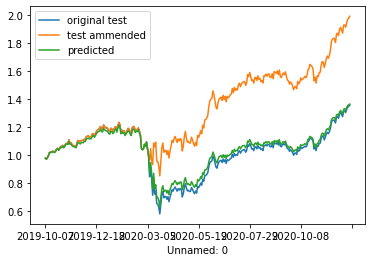

In [18]:
# datas intressantes 2018-10-31
# 2020-12-19

lp_test = experiments_cache['2020-12-19']['train']['lp']
lp_test_ammended = experiments_cache['2020-12-19']['train']['lp_ammended']
lp_predicted = experiments_cache['2020-12-19']['train']['lp_predicted']

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

<AxesSubplot:>

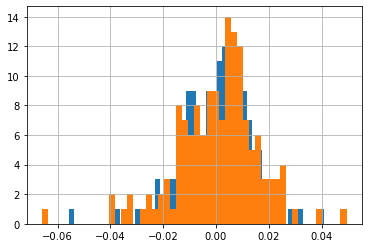

In [19]:
experiments_cache['2020-12-19']['test']['portfolio_returns_pred'].hist(bins = 50)
experiments_cache['2020-12-19']['test']['lp'].pct_change().hist(bins = 50)

<AxesSubplot:xlabel='Unnamed: 0'>

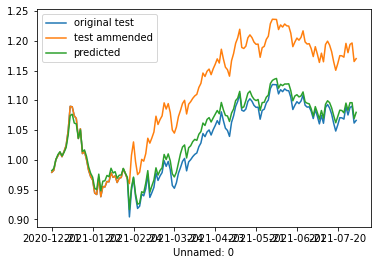

In [20]:
lp_test = experiments_cache['2020-12-19']['test']['lp']
lp_test_ammended = experiments_cache['2020-12-19']['test']['lp_ammended']
lp_predicted = experiments_cache['2020-12-19']['test']['lp_predicted']

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

## Metrixs distribution

In [21]:
train_diffs_max, test_diffs_max, train_diffs_mean, test_diffs_mean = [], [], [], []
pos_perc_train, pos_perc_test = [], []

for k,v in experiments_cache.items():
    train_diffs_max.append(np.max(v['train']['diff_pred_benchmark']))
    test_diffs_max.append(np.max(v['test']['diff_pred_benchmark']))
    train_diffs_mean.append(np.mean(v['train']['diff_pred_benchmark']))
    test_diffs_mean.append(np.mean(v['test']['diff_pred_benchmark']))
    
    positive_train = 0
    for i in range(len(v['train']['diff_pred_benchmark'])):
        if v['train']['diff_pred_benchmark'][i] >= 0:
            positive_train += 1
        
    pos_perc_train.append(positive_train / len(v['train']['diff_pred_benchmark']))
    
    positive_test = 0
    for i in range(len(v['test']['diff_pred_benchmark'])):
        if v['test']['diff_pred_benchmark'][i] >= 0:
            positive_test += 1
    
    pos_perc_test.append(positive_test / len(v['test']['diff_pred_benchmark']))
    


### deflated sharpe value
https://quantdare.com/deflated-sharpe-ratio-how-to-avoid-been-fooled-by-randomness/

In [62]:
sr

-2.316057250457407

In [46]:
r_p = (return_final - return_init) / return_init

0.018745206407478385

In [55]:
np.std(experiments_cache['2013-03-01']['test']['lp_predicted'])

0.05423427394375271

In [53]:
return_init*(1+0.018745206407478385)

1.0126812796843812

<AxesSubplot:>

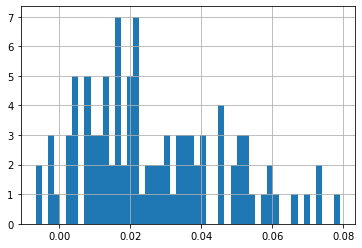

In [22]:
#pd.Series(train_diffs_max).hist(bins = 50)
pd.Series(test_diffs_max).hist(bins = 50)

<AxesSubplot:>

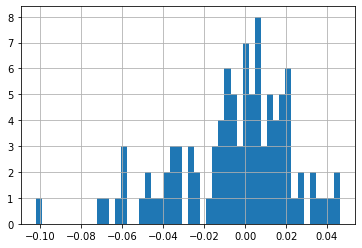

In [64]:
#pd.Series(train_diffs_mean).hist(bins = 50)
pd.Series(test_diffs_mean).hist(bins = 50)

<AxesSubplot:>

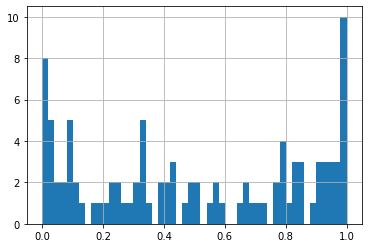

In [65]:
#pd.Series(pos_perc_train).hist(bins=50)
pd.Series(pos_perc_test).hist(bins=50)

As the mean is zero, there is no significant difference between the original return given by the risk factor from the eigenportfolio, which means the initial hyphotesis that non-lineraities seeked by a defined target are not found or present.

Next ideas: is go from step 1 of deepportfolios to harness least-communal stocks for the specific target!

is is random!

# methods

In [775]:
## Test

## set the y_objectve

"""
weights_expriment = [0.15, 0.2, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#weights_expriment = sector_returns['weights']
y_train_exp = df_returns_train[1:].apply(lambda x: np.dot(weights_expriment, np.transpose(x)), axis = 1)

encoder_params_exp = {'encoding_dim': 6,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'softmax'}


#model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train[1:], encoder_params)
model_exp = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_exp, encoder_params_exp)


# train
portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model_exp))
pd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)
#portfolio_returns_train_hat.plot(label = 'predicted', legend = True)
y_train_exp.plot(label = 'ammended', legend = True)

# test
lp_test =  ((y_train_exp + 1).cumprod())
lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

"""

"\nweights_expriment = [0.15, 0.2, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]\n#weights_expriment = sector_returns['weights']\ny_train_exp = df_returns_train[1:].apply(lambda x: np.dot(weights_expriment, np.transpose(x)), axis = 1)\n\nencoder_params_exp = {'encoding_dim': 6,\n                  'optimizer':'sgd', \n                  'loss':'mean_squared_error',\n                  'l2_penalty': 0.01, \n                  'epochs': 500, \n                  'batch_size': 100, \n                  'shuffle' : False,\n                  'output_activation': 'softmax'}\n\n\n#model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train[1:], encoder_params)\nmodel_exp = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_exp, encoder_params_exp)\n\n\n# train\nportfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model_exp))\npd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)\n#portfolio_returns_train_hat.plot(la

In [384]:
help(Dense)

Help on class Dense in module keras.layers.core.dense:

class Dense(keras.engine.base_layer.Layer)
 |  Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  Just your regular densely-connected NN layer.
 |  
 |  `Dense` implements the operation:
 |  `output = activation(dot(input, kernel) + bias)`
 |  where `activation` is the element-wise activation function
 |  passed as the `activation` argument, `kernel` is a weights matrix
 |  created by the layer, and `bias` is a bias vector created by the layer
 |  (only applicable if `use_bias` is `True`). These are all attributes of
 |  `Dense`.
 |  
 |  Note: If the input to the layer has a rank greater than 2, then `Dense`
 |  computes the dot product between the `inputs` and the `kernel` along the
 |  last axis of the `inputs` and axis 0 of the `kern

In [13]:
encoder_params = {'encoding_dim': 5,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.001, 
                  'epochs': 500, 
                  'batch_size': 10, 
                  'shuffle' : False}


from tensorflow.python.ops import math_ops
#We used our own loss function because the one provided by tensorflow was not consistent
"""def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.compat.v1.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

def mse(output, x):
    with tf.compat.v1.variable_scope('mse'):
        mse = tf.math.squared_difference(output, x)
    return mse"""

def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    output_activation = network_params['output_activation']
    
    # target tensor -> y_target
    target = Input(shape=(1,))
    # connect all layers
    input_tensor = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='tanh', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    #decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    decoded = Dense(x.shape[1], activation= output_activation, kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    
    
  
    def custom_rmse_loss(y_true, y_pred, input_tensor):

        y_pred_dot = K.dot(y_pred, K.transpose(input_tensor))
        loss = K.sqrt(K.mean(K.square(y_pred_dot - y_true))) 
        
        return loss
    
 
    
    # construct and compile deep learning routine
    deep_learner = Model([input_tensor, target], decoded)
    
    deep_learner.add_loss(custom_rmse_loss(target, decoded, input_tensor))
    deep_learner.compile(optimizer=optimizer, loss = None, run_eagerly=True)
    #deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)
    
    deep_learner.fit([x, y_target] , None, shuffle=shuffle, epochs=epochs, batch_size = batch_size)
    
    # this make inferences compatible
    final_model = Model(deep_learner.input[0], deep_learner.output)
    
    return final_model



def autoencoder_short_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    output_activation = network_params['output_activation']
    
    # target tensor -> y_target
    target = Input(shape=(1,))
    # connect all layers
    input_tensor = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='tanh', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    #decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    decoded = Dense(x.shape[1], activation= output_activation, kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    return_ = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(decoded)
    
 
    # construct and compile deep learning routine
    deep_learner = Model(input_tensor, return_)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)
    
    
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    

    return deep_learner


def portfolio_returns_predict(x, model):
    "Get the models weights to estimate returns"
    weights = copy.deepcopy(model.predict(x))
    x = np.array(x)
    returns = []
    for i in range(len(weights)):
        returns.append(np.dot(weights[i], np.transpose(x[i])))
    # is not a single weight
    #weights = K.eval(model.layers[2].weights[1])
    #weights = weights / len(weights)
    #returns = x.apply(lambda row: np.dot(weights,  np.transpose(row)), axis = 1)
    return returns

def short_portfolio_predict(x, model):
    weights = K.eval(model.layers[2].weights[1])
    returns = x.apply(lambda row: np.dot(weights,  np.transpose(row)), axis = 1)
    return np.array(returns)

def two_norm_diff(y, y_hat):
    return np.linalg.norm((y_hat - y))


#deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use

## TEST

## Backlog

In [528]:


# Calibration test
def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    
    # connect all layers
    input_img = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)

    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer=optimizer, loss=loss)

    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)  
    
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    return deep_learner




In [ ]:
"""
def CustomLoss(y_true, y_pred, input_tensor):
    print(y_pred)
    return K.binary_crossentropy(y_true, y_pred) + K.mean(input_tensor)

X = np.random.uniform(0,1, (1000,10))
y = np.random.randint(0,2, 1000)

inp = Input(shape=(10,))
hidden = Dense(100, activation='relu')(inp)
out = Dense(1, activation='sigmoid')(hidden)
target = Input((1,))
model = Model([inp,target], out)

model.add_loss( CustomLoss( target, out, inp ) )
model.compile(loss=None, optimizer='adam')
model.fit(x=[X,y], y=None, epochs=3)
"""

deep_learner = Model(input_tensor, decoded)
    
    def custom_loss(input_tensor):
        def _loss(y_true, y_pred):
            
            K.print_tensor(input_tensor, message='input_tensor = ')
            #K.print_tensor(y_pred, message='y_pred = ')
            
            #y_pred = K.dot(y_pred, input_tensor)
            diff = math_ops.squared_difference(y_pred, y_true)  #squared difference
            loss = K.mean(diff, axis=-1) #mean over last dimension
            return loss
        return _loss
    
    deep_learner.compile(optimizer=optimizer, loss=custom_loss(input_tensor))
